# Import Libraries

In [1]:
import time

import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import difflib

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_fscore_support, classification_report


# Import Data

In [2]:
df_raw = pd.read_csv('League_Info.csv', index_col=0)

df_match = pd.read_csv('Match_Info.csv', index_col=0)
df_match.reset_index(inplace=True)

df_team = pd.read_csv('Team_Info.csv', index_col=0)
df_team.reset_index(inplace=True)
df_team.rename(columns={'Team': 'Home_Team'}, inplace=True)

elo_dict = pickle.load(open('elo_dict.pkl', 'rb'))
df_elo = pd.DataFrame.from_dict(elo_dict, orient='index')
df_elo.reset_index(inplace=True)
df_elo.rename(columns={'index': 'Link', 'Elo_home': 'Home_ELO', 'Elo_away': 'Away_ELO'}, inplace=True)


# Data Cleaning and Exploratory Data Analysis

### Individual DataFrames

In [3]:
def link_clean(x):
    i=x.rfind('/')
    return x[:i+5]

#print(df_raw['Link'].value_counts().value_counts())
df_raw['Link'] = df_raw['Link'].apply(lambda x: link_clean(x))
#print(df_raw['Link'].value_counts().value_counts())
df_raw


Home_Team        Away_Team Result  \
0            Millwall  Southend United    3-1   
1          Portsmouth     Notts County    2-1   
2          Stoke City  Tranmere Rovers    1-0   
3            Barnsley     Derby County    2-1   
4       Middlesbrough          Burnley    2-0   
...               ...              ...    ...   
146493      Frosinone     Pro Vercelli    2-1   
146494        Perugia      Salernitana    3-2   
146495       Vicenza            Spezia    0-1   
146496         Ascoli   Ternana Calcio    1-2   
146497        Brescia          Trapani    2-1   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...    1995      1   
1       https://www.besoccer.com/match/portsmouth/nott...    1995      1   
2       https://www.besoccer.com/match/stoke-city/tran...    1995      1   
3       https://www.besoccer.com/match/barnsley-fc/der...    1995      1   
4       https://www.besoccer.com/match/middlesbrough-f...    1995      1   
...                                                   ...     ...    ...   
146493  https://www.besoccer.com/match/frosinone-calci...    2017     42   
146494  https://www.besoccer.com/match/perugia/salerni...    2017     42   
146495  https://www.besoccer.com/match/vicenza-calcio/...    2017     42   
146496  https://www.besoccer.com/match/ascoli/ternana-...    2017     42   
146497  https://www.besoccer.com/match/brescia/trapani...    2017     42   

              League  
0       championship  
1       championship  
2       championship  
3       championship  
4       championship  
...              ...  
146493       serie_b  
146494       serie_b  
146495       serie_b  
146496       serie_b  
146497       serie_b  

[146498 rows x 7 columns]

In [4]:
df_match['Link'] = df_match['Link'].apply(lambda x: 'https://www.besoccer.com' + x)
df_match

Link  \
0       https://www.besoccer.com/match/saarbrucken/stu...   
1       https://www.besoccer.com/match/sc-freiburg/unt...   
2       https://www.besoccer.com/match/vfl-osnabruck/m...   
3       https://www.besoccer.com/match/rot-weiss-essen...   
4       https://www.besoccer.com/match/alemannia-aache...   
...                                                   ...   
143343  https://www.besoccer.com/match/sunderland-afc/...   
143344  https://www.besoccer.com/match/fc-gueugnon/bas...   
143345  https://www.besoccer.com/match/tranmere-rovers...   
143346  https://www.besoccer.com/match/sochaux/guingam...   
143347  https://www.besoccer.com/match/huddersfield-to...   

                                  Date_New  \
0            Saturday, 29 July 1989, 15:00   
1            Saturday, 29 July 1989, 15:00   
2            Saturday, 29 July 1989, 15:00   
3            Saturday, 29 July 1989, 15:00   
4            Saturday, 29 July 1989, 15:00   
...                                    ...   
143343  Saturday, 19 September 1998, 00:00   
143344         Tuesday, 17 May 1994, 00:00   
143345      Friday, 08 January 1999, 00:00   
143346   Saturday, 27 February 2021, 19:00   
143347   Saturday, 05 December 1998, 00:00   

                                     Referee  Home_Yellow  Home_Red  \
0         \r\nReferee: Hans-Jürgen Weber\r\n          0.0       0.0   
1               \r\nReferee: Kurt Wittke\r\n          1.0       0.0   
2            \r\nReferee: Werner Föckler\r\n          3.0       0.0   
3              \r\nReferee: Heinz Werner\r\n          2.0       0.0   
4       \r\nReferee: Hans-Peter Dellwing\r\n          1.0       0.0   
...                                      ...          ...       ...   
143343        \r\nReferee: Anthony Leake\r\n          1.0       0.0   
143344      \r\nReferee: Jacques Poulain\r\n          0.0       0.0   
143345          \r\nReferee: Kevin Lynch\r\n          2.0       0.0   
143346             \r\nReferee: Baert A.\r\n          0.0       0.0   
143347          \r\nReferee: George Cain\r\n          1.0       0.0   

        Away_Yellow  Away_Red  
0               3.0       0.0  
1               0.0       0.0  
2               2.0       0.0  
3               2.0       0.0  
4               1.0       0.0  
...             ...       ...  
143343          0.0       0.0  
143344          0.0       0.0  
143345          1.0       0.0  
143346          2.0       0.0  
143347          1.0       0.0  

[143348 rows x 7 columns]

In [5]:
df_team

Home_Team                 City  Country  \
0    Wattenscheid 09  Bochum-Wattenscheid  Germany   
1         Hertha BSC               Berlín  Germany   
2       Unterhaching         Unterhaching  Germany   
3       Fortuna Köln              Cologne  Germany   
4       MSV Duisburg            Duisburgo  Germany   
..               ...                  ...      ...   
539           Latina               Latina    Italy   
540   Virtus Entella             Chiavari    Italy   
541    Nuova Cosenza              Cosenza    Italy   
542        Pordenone            Pordenone    Italy   
543       Bourges 18              Bourges   France   

                                Stadium Capacity              Pitch  
0                      Lohrheidestadion    16233            Natural  
1                 Olympiastadion Berlin    76065            Natural  
2                Sportpark Unterhaching    15053            Natural  
3                            Südstadion    14944            Natural  
4             Schauinsland-Reisen-Arena    31514            Natural  
..                                  ...      ...                ...  
539  Stadio Comunale Domenico Francioni     8000            Natural  
540            Stadio Comunale Chiavari     4154  Césped Artificial  
541                     Stadio San Vito    24209            Natural  
542                                 NaN     3089                NaN  
543                                 NaN   13,000                NaN  

[544 rows x 6 columns]

In [6]:
def link_clean(x):
    i=x.rfind('/')
    return x[:i+5]

#print(df_elo['Link'].value_counts().value_counts())
df_elo['Link'] = df_elo['Link'].apply(lambda x: link_clean(x))
#print(df_elo['Link'].value_counts().value_counts())
df_elo

Link  Home_ELO  Away_ELO
0       https://www.besoccer.com/match/saarbrucken/stu...      56.0      59.0
1       https://www.besoccer.com/match/sc-freiburg/unt...      53.0      55.0
2       https://www.besoccer.com/match/vfl-osnabruck/m...      52.0      53.0
3       https://www.besoccer.com/match/rot-weiss-essen...      53.0      62.0
4       https://www.besoccer.com/match/alemannia-aache...      57.0      52.0
...                                                   ...       ...       ...
132106  https://www.besoccer.com/match/lecce/spal-1907...      59.0      59.0
132107  https://www.besoccer.com/match/frosinone-calci...      58.0      57.0
132108  https://www.besoccer.com/match/reggina/vicenza...      40.0      49.0
132109  https://www.besoccer.com/match/venezia/nuova-c...      54.0      47.0
132110  https://www.besoccer.com/match/chievo/pisa-cal...      64.0      56.0

[132111 rows x 3 columns]

### Combine Dataframes + Standardise Team Names

In [7]:
# Standardise team names
ht = set(df_raw['Home_Team'].tolist())
at = set(df_raw['Away_Team'].tolist())
tt = set(df_team['Home_Team'].tolist())

all_teams = set.union(ht, at, tt)

#print(len(tt), len(all_teams))

# Create dictionary of team names to standardise (i.e. base on teams in df_team)
teams_dict = {}
for team in all_teams:
    try:
        new_name = difflib.get_close_matches(team, tt)[0]
    except:
        new_name = team
    teams_dict[team] = new_name

df_raw['Home_Team'] = df_raw['Home_Team'].apply(lambda x: teams_dict[x])
df_raw['Away_Team'] = df_raw['Away_Team'].apply(lambda x: teams_dict[x])
df_team['Home_Team'] = df_team['Home_Team'].apply(lambda x: teams_dict[x])

In [8]:
df = pd.merge(df_raw, df_match, on='Link', how='outer')
df = pd.merge(df, df_team, on='Home_Team', how='outer')
df = pd.merge(df, df_elo, on='Link', how='outer')
df

Home_Team           Away_Team Result  \
0              Millwall     Southend United    3-1   
1              Millwall        Derby County    4-1   
2              Millwall  West Bromwich Alb.    2-2   
3              Millwall             Burnley    2-3   
4              Millwall          Luton Town    0-0   
...                 ...                 ...    ...   
161489  Oriental Lisboa                 NaN    NaN   
161490             Fafe                 NaN    NaN   
161491         Casa Pia                 NaN    NaN   
161492   Vilafranquense                 NaN    NaN   
161493           Calcio                 NaN    NaN   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
161489                                                NaN     NaN    NaN   
161490                                                NaN     NaN    NaN   
161491                                                NaN     NaN    NaN   
161492                                                NaN     NaN    NaN   
161493                                                NaN     NaN    NaN   

              League                             Date_New Referee  \
0       championship      Saturday, 13 August 1994, 00:00    \r\n   
1       championship      Saturday, 27 August 1994, 00:00    \r\n   
2       championship   Saturday, 10 September 1994, 00:00    \r\n   
3       championship  Wednesday, 14 September 1994, 00:00    \r\n   
4       championship   Saturday, 24 September 1994, 00:00    \r\n   
...              ...                                  ...     ...   
161489           NaN                                  NaN     NaN   
161490           NaN                                  NaN     NaN   
161491           NaN                                  NaN     NaN   
161492           NaN                                  NaN     NaN   
161493           NaN                                  NaN     NaN   

        Home_Yellow  Home_Red  Away_Yellow  Away_Red                 City  \
0               NaN       NaN          NaN       NaN              Londres   
1               NaN       NaN          NaN       NaN              Londres   
2               NaN       NaN          NaN       NaN              Londres   
3               NaN       NaN          NaN       NaN              Londres   
4               NaN       NaN          NaN       NaN              Londres   
...             ...       ...          ...       ...                  ...   
161489          NaN       NaN          NaN       NaN               Lisbon   
161490          NaN       NaN          NaN       NaN                 Fafe   
161491          NaN       NaN          NaN       NaN               Lisboa   
161492          NaN       NaN          NaN       NaN  Vila Franca de Xira   
161493          NaN       NaN          NaN       NaN               Foggia   

         Country                         Stadium Capacity    Pitch  Home_ELO  \
0        England                         The Den    20146  Natural       NaN   
1        England                         The Den    20146  Natural       NaN   
2        England                         The Den    20146  Natural       NaN   
3        England                         The Den    20146  Natural       NaN   
4        England                         The Den    20146  Natural       NaN   
...          ...                             ...      ...      ...       ...   
161489  Portugal  Campo Engenheiro Carlos Salema     8500      NaN       NaN   
161490  Portugal                             NaN     8000 

### Data Cleaning + Feature Engineering

Remove rows that are missing key features for the model

In [9]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['Home_Team', 'Away_Team', 'Result'], inplace=True)
df

Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                             Date_New  \
0       championship      Saturday, 13 August 1994, 00:00   
1       championship      Saturday, 27 August 1994, 00:00   
2       championship   Saturday, 10 September 1994, 00:00   
3       championship  Wednesday, 14 September 1994, 00:00   
4       championship   Saturday, 24 September 1994, 00:00   
...              ...                                  ...   
146501       serie_b       Saturday, 24 March 2012, 15:00   
146502       serie_b         Friday, 06 April 2012, 19:00   
146503       serie_b       Saturday, 21 April 2012, 15:00   
146504       serie_b         Saturday, 05 May 2012, 15:00   
146505       serie_b           Sunday, 20 May 2012, 15:00   

                                     Referee  Home_Yellow  Home_Red  \
0                                       \r\n          NaN       NaN   
1                                       \r\n          NaN       NaN   
2                                       \r\n          NaN       NaN   
3                                       \r\n          NaN       NaN   
4                                       \r\n          NaN       NaN   
...                                      ...          ...       ...   
146501      \r\nReferee: Renzo Candussio\r\n          2.0       0.0   
146502         \r\nReferee: Dino Tommasi\r\n          3.0       0.0   
146503  \r\nReferee: Gianpaolo Calvarese\r\n          1.0       0.0   
146504       \r\nReferee: Marco Di Bello\r\n          2.0       0.0   
146505      \r\nReferee: Maurizio Ciampi\r\n          1.0       0.0   

        Away_Yellow  Away_Red              City  Country  \
0               NaN       NaN           Londres  England   
1               NaN       NaN           Londres  England   
2               NaN       NaN           Londres  England   
3               NaN       NaN           Londres  England   
4               NaN       NaN           Londres  England   
...             ...       ...               ...      ...   
146501          2.0       0.0  Nocera Inferiore    Italy   
146502          3.0       0.0  Nocera Inferiore    Italy   
146503          3.0       0.0  Nocera Inferiore    Italy   
146504          3.0       0.0  Nocera Inferiore    Italy   
146505          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  
0                    The Den    20146  Natural       NaN       NaN  
1                    The Den    20146  Natural       NaN       NaN  
2              

Clean the results column, by removing invalid results, and create new columns for more interpretable features. These features are:
- Home Team score
- Away Team Score
- Home Team Result (Win/ Loss/ Draw)
- Away Team Result (Win/ Loss/ Draw)

In [10]:
# Check results are valid outcomes
#print(df['Result'].str.len().value_counts())

# Drop 'Results' that do not add value to analysis or don't make sense (i.e. len(str(x)) !=3)
df.drop(df[df['Result'].str.len() != 3].index, inplace=True)

# Convert results string to Home Team and Away Team scores as Integars
df['Home_Team_Score'] = df['Result'].apply(lambda x: int(x.split('-')[0]))
df['Away_Team_Score'] = df['Result'].apply(lambda x: int(x.split('-')[1]))
df


Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                             Date_New  \
0       championship      Saturday, 13 August 1994, 00:00   
1       championship      Saturday, 27 August 1994, 00:00   
2       championship   Saturday, 10 September 1994, 00:00   
3       championship  Wednesday, 14 September 1994, 00:00   
4       championship   Saturday, 24 September 1994, 00:00   
...              ...                                  ...   
146501       serie_b       Saturday, 24 March 2012, 15:00   
146502       serie_b         Friday, 06 April 2012, 19:00   
146503       serie_b       Saturday, 21 April 2012, 15:00   
146504       serie_b         Saturday, 05 May 2012, 15:00   
146505       serie_b           Sunday, 20 May 2012, 15:00   

                                     Referee  Home_Yellow  Home_Red  \
0                                       \r\n          NaN       NaN   
1                                       \r\n          NaN       NaN   
2                                       \r\n          NaN       NaN   
3                                       \r\n          NaN       NaN   
4                                       \r\n          NaN       NaN   
...                                      ...          ...       ...   
146501      \r\nReferee: Renzo Candussio\r\n          2.0       0.0   
146502         \r\nReferee: Dino Tommasi\r\n          3.0       0.0   
146503  \r\nReferee: Gianpaolo Calvarese\r\n          1.0       0.0   
146504       \r\nReferee: Marco Di Bello\r\n          2.0       0.0   
146505      \r\nReferee: Maurizio Ciampi\r\n          1.0       0.0   

        Away_Yellow  Away_Red              City  Country  \
0               NaN       NaN           Londres  England   
1               NaN       NaN           Londres  England   
2               NaN       NaN           Londres  England   
3               NaN       NaN           Londres  England   
4               NaN       NaN           Londres  England   
...             ...       ...               ...      ...   
146501          2.0       0.0  Nocera Inferiore    Italy   
146502          3.0       0.0  Nocera Inferiore    Italy   
146503          3.0       0.0  Nocera Inferiore    Italy   
146504          3.0       0.0  Nocera Inferiore    Italy   
146505          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2           

In [11]:
def result(x):
    if x['Home_Team_Score'] > x['Away_Team_Score']:
        return 'Win'

    elif x['Home_Team_Score'] == x['Away_Team_Score']:
        return 'Draw'
    else:
        return 'Loss'

df['Home_Team_Result'] = df.apply(lambda x: result(x), axis=1)

def result(x):
    if x['Home_Team_Score'] < x['Away_Team_Score']:
        return 'Win'

    elif x['Home_Team_Score'] == x['Away_Team_Score']:
        return 'Draw'
    else:
        return 'Loss'

df['Away_Team_Result'] = df.apply(lambda x: result(x), axis=1)
df

Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                             Date_New  \
0       championship      Saturday, 13 August 1994, 00:00   
1       championship      Saturday, 27 August 1994, 00:00   
2       championship   Saturday, 10 September 1994, 00:00   
3       championship  Wednesday, 14 September 1994, 00:00   
4       championship   Saturday, 24 September 1994, 00:00   
...              ...                                  ...   
146501       serie_b       Saturday, 24 March 2012, 15:00   
146502       serie_b         Friday, 06 April 2012, 19:00   
146503       serie_b       Saturday, 21 April 2012, 15:00   
146504       serie_b         Saturday, 05 May 2012, 15:00   
146505       serie_b           Sunday, 20 May 2012, 15:00   

                                     Referee  Home_Yellow  Home_Red  \
0                                       \r\n          NaN       NaN   
1                                       \r\n          NaN       NaN   
2                                       \r\n          NaN       NaN   
3                                       \r\n          NaN       NaN   
4                                       \r\n          NaN       NaN   
...                                      ...          ...       ...   
146501      \r\nReferee: Renzo Candussio\r\n          2.0       0.0   
146502         \r\nReferee: Dino Tommasi\r\n          3.0       0.0   
146503  \r\nReferee: Gianpaolo Calvarese\r\n          1.0       0.0   
146504       \r\nReferee: Marco Di Bello\r\n          2.0       0.0   
146505      \r\nReferee: Maurizio Ciampi\r\n          1.0       0.0   

        Away_Yellow  Away_Red              City  Country  \
0               NaN       NaN           Londres  England   
1               NaN       NaN           Londres  England   
2               NaN       NaN           Londres  England   
3               NaN       NaN           Londres  England   
4               NaN       NaN           Londres  England   
...             ...       ...               ...      ...   
146501          2.0       0.0  Nocera Inferiore    Italy   
146502          3.0       0.0  Nocera Inferiore    Italy   
146503          3.0       0.0  Nocera Inferiore    Italy   
146504          3.0       0.0  Nocera Inferiore    Italy   
146505          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2           

In [12]:
df = df.join(pd.get_dummies(df['Home_Team_Result'], prefix='Home_Team'))
df = df.join(pd.get_dummies(df['Away_Team_Result'], prefix='Away_Team'))
df

Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                             Date_New  \
0       championship      Saturday, 13 August 1994, 00:00   
1       championship      Saturday, 27 August 1994, 00:00   
2       championship   Saturday, 10 September 1994, 00:00   
3       championship  Wednesday, 14 September 1994, 00:00   
4       championship   Saturday, 24 September 1994, 00:00   
...              ...                                  ...   
146501       serie_b       Saturday, 24 March 2012, 15:00   
146502       serie_b         Friday, 06 April 2012, 19:00   
146503       serie_b       Saturday, 21 April 2012, 15:00   
146504       serie_b         Saturday, 05 May 2012, 15:00   
146505       serie_b           Sunday, 20 May 2012, 15:00   

                                     Referee  Home_Yellow  Home_Red  \
0                                       \r\n          NaN       NaN   
1                                       \r\n          NaN       NaN   
2                                       \r\n          NaN       NaN   
3                                       \r\n          NaN       NaN   
4                                       \r\n          NaN       NaN   
...                                      ...          ...       ...   
146501      \r\nReferee: Renzo Candussio\r\n          2.0       0.0   
146502         \r\nReferee: Dino Tommasi\r\n          3.0       0.0   
146503  \r\nReferee: Gianpaolo Calvarese\r\n          1.0       0.0   
146504       \r\nReferee: Marco Di Bello\r\n          2.0       0.0   
146505      \r\nReferee: Maurizio Ciampi\r\n          1.0       0.0   

        Away_Yellow  Away_Red              City  Country  \
0               NaN       NaN           Londres  England   
1               NaN       NaN           Londres  England   
2               NaN       NaN           Londres  England   
3               NaN       NaN           Londres  England   
4               NaN       NaN           Londres  England   
...             ...       ...               ...      ...   
146501          2.0       0.0  Nocera Inferiore    Italy   
146502          3.0       0.0  Nocera Inferiore    Italy   
146503          3.0       0.0  Nocera Inferiore    Italy   
146504          3.0       0.0  Nocera Inferiore    Italy   
146505          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2           

Check Season, Round and League features

(array([1985., 1990., 1995., 2000., 2005., 2010., 2015., 2020., 2025.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

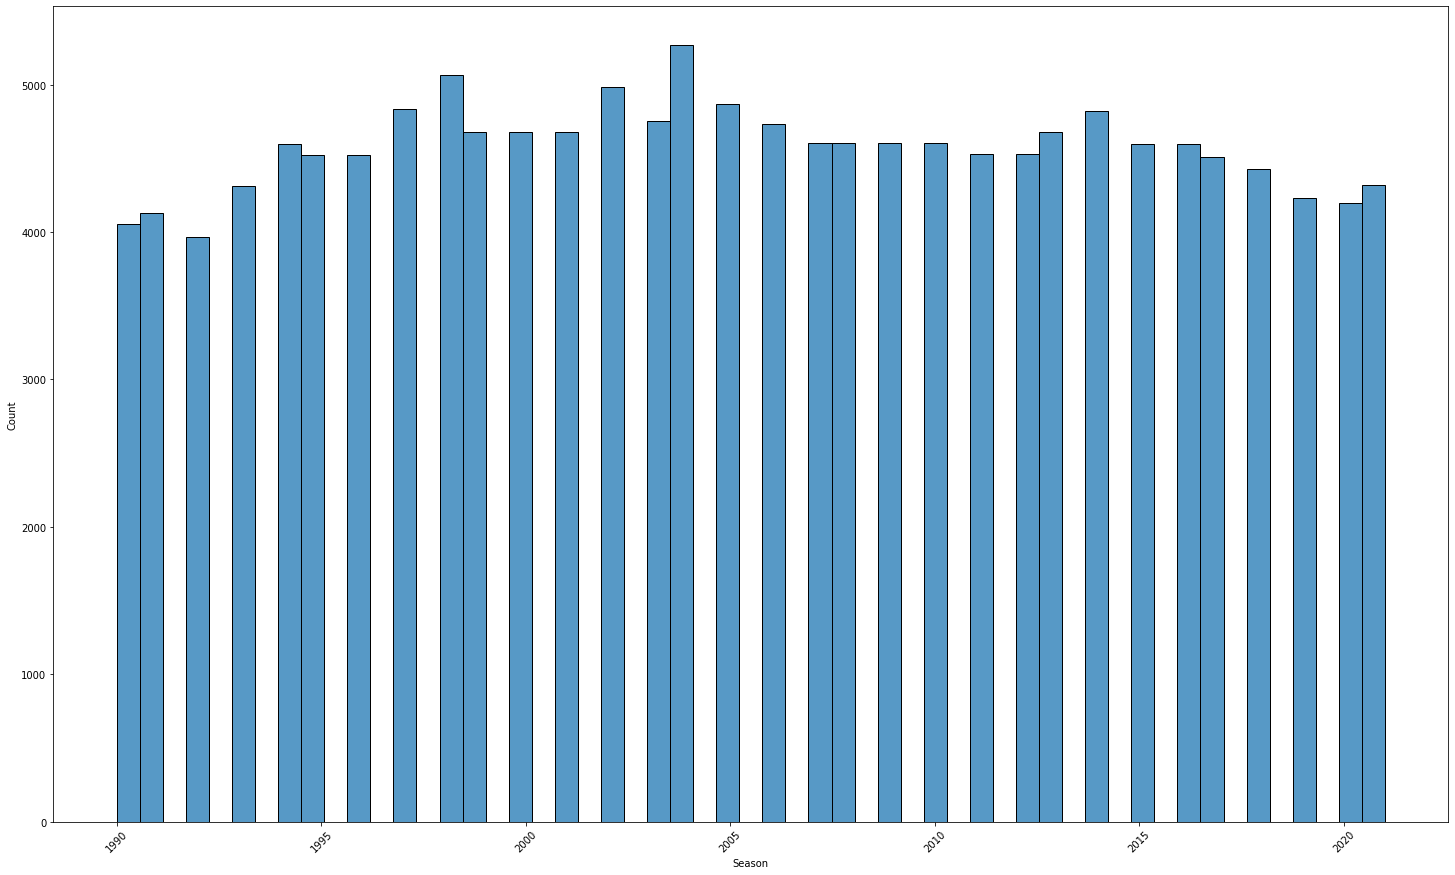

In [13]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Season')
plt.xticks(rotation=45)

#df['Season'].value_counts().sort_index()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

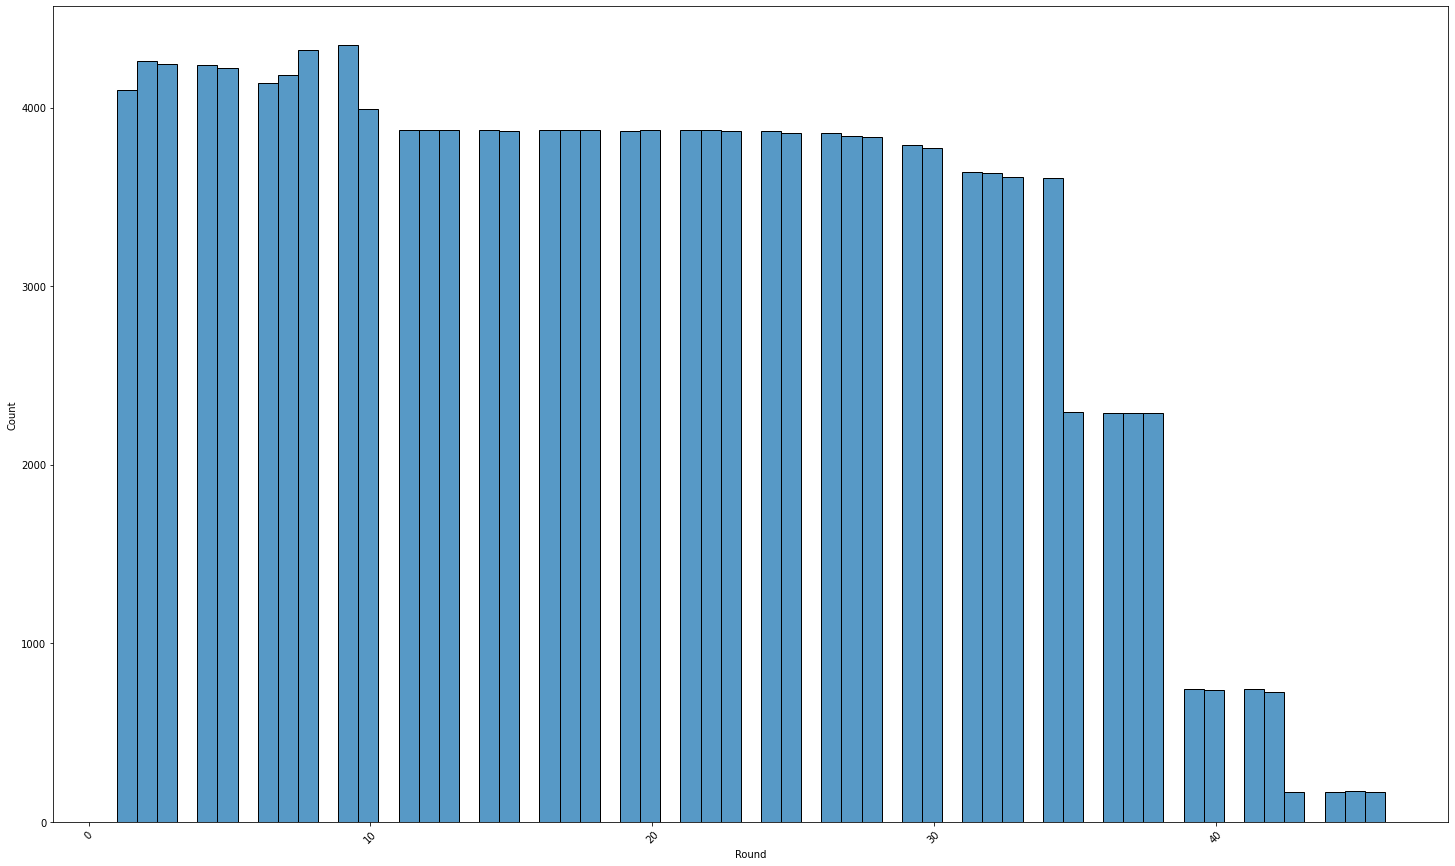

In [14]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Round')
plt.xticks(rotation=45)

#df['Round'].value_counts().sort_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

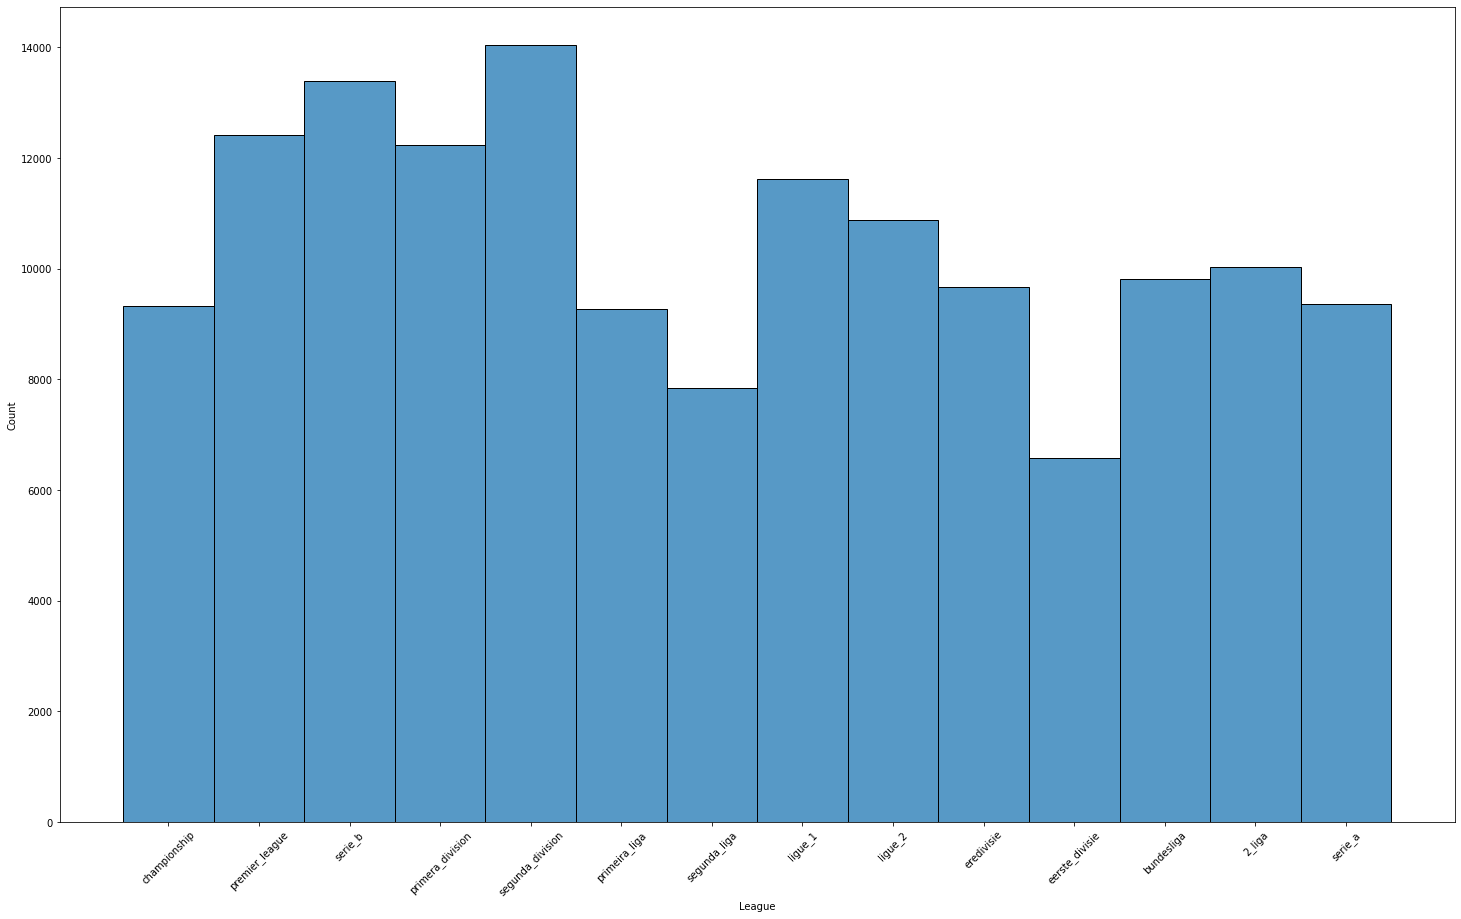

In [15]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='League')
plt.xticks(rotation=45)

#df['League'].value_counts().sort_index()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146487 entries, 0 to 146505
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Home_Team         146487 non-null  object 
 1   Away_Team         146487 non-null  object 
 2   Result            146487 non-null  object 
 3   Link              146487 non-null  object 
 4   Season            146487 non-null  float64
 5   Round             146487 non-null  float64
 6   League            146487 non-null  object 
 7   Date_New          142526 non-null  object 
 8   Referee           142526 non-null  object 
 9   Home_Yellow       122562 non-null  float64
 10  Home_Red          122562 non-null  float64
 11  Away_Yellow       122562 non-null  float64
 12  Away_Red          122562 non-null  float64
 13  City              145513 non-null  object 
 14  Country           145513 non-null  object 
 15  Stadium           135680 non-null  object 
 16  Capacity          14

Some of the values in the date new column do not seem plausable (e.g. 388 games happening simulatiously with only a total of 550 teams).

Convert Date_new feature into more useable features:

New features are as follows:
- Time
- Day
- Date
- Month
- Year

In [17]:
def date_split(x, value):
    x = x.split(', ')
    if len(x) == 3:
        if value=='Time':
            return x[-1].strip()
        elif value=='Day':
            return x[0].strip()

        elif value=='Date':
            x = x[1]
            x = x.split(' ')
            return int(x[0].strip())

        elif value=='Month':
            x = x[1]
            x = x.split(' ')
            return x[1].strip()

        elif value=='Year':
            x = x[1]
            x = x.split(' ')
            return int(x[2].strip())

        else:
            return 'NA'

    else:
        if value=='Time':
            return 'NA'

        elif value=='Date':
            x = x[1]
            x = x.split(' ')
            return int(x[0].strip())

        elif value=='Month':
            x = x[1]
            x = x.split(' ')
            return x[1].strip()

        elif value=='Year':
            x = x[1]
            x = x.split(' ')
            return int(x[2].strip())

        else:
            return 'NA'


In [18]:
df['Time'] = df.loc[~df['Date_New'].isna(),'Date_New'].apply(lambda x: date_split(x, 'Time'))
df['Day'] = df.loc[~df['Date_New'].isna(),'Date_New'].apply(lambda x: date_split(x, 'Day'))
df['Date'] = df.loc[~df['Date_New'].isna(),'Date_New'].apply(lambda x: date_split(x, 'Date'))
df['Month'] = df.loc[~df['Date_New'].isna(),'Date_New'].apply(lambda x: date_split(x, 'Month'))
df['Year'] = df.loc[~df['Date_New'].isna(),'Date_New'].apply(lambda x: date_split(x, 'Year'))

df.drop(columns='Date_New', inplace=True)
df = df.loc[df['Day'] != 'NA']

df

Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
0       championship                                  \r\n          NaN   
1       championship                                  \r\n          NaN   
2       championship                                  \r\n          NaN   
3       championship                                  \r\n          NaN   
4       championship                                  \r\n          NaN   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n          2.0   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n          3.0   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n          1.0   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n          2.0   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n          1.0   

        Home_Red  Away_Yellow  Away_Red              City  Country  \
0            NaN          NaN       NaN           Londres  England   
1            NaN          NaN       NaN           Londres  England   
2            NaN          NaN       NaN           Londres  England   
3            NaN          NaN       NaN           Londres  England   
4            NaN          NaN       NaN           Londres  England   
...          ...          ...       ...               ...      ...   
146501       0.0          2.0       0.0  Nocera Inferiore    Italy   
146502       0.0          3.0       0.0  Nocera Inferiore    Italy   
146503       0.0          3.0       0.0  Nocera Inferiore    Italy   
146504       0.0          3.0       0.0  Nocera Inferiore    Italy   
146505       0.0          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2                    The Den    20146  Natural       NaN       NaN   
3                    The Den    20146  Natural       NaN       NaN   
4                    The Den    20146  Natural       NaN       NaN   
...                      ...      ...      ...       ...       ...   
146501  Stadio San Francesco     9998  Natural      40.0      54.0   
146502  Stadio San Francesco     9998  Natural      40.0      63.0   
146503  Stadio San Francesco     9998  Natural      41.0      59.0   
146504  Stadio San Francesco     9998  Natural      40.0      53.0   
146505  Stadio Sa

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text

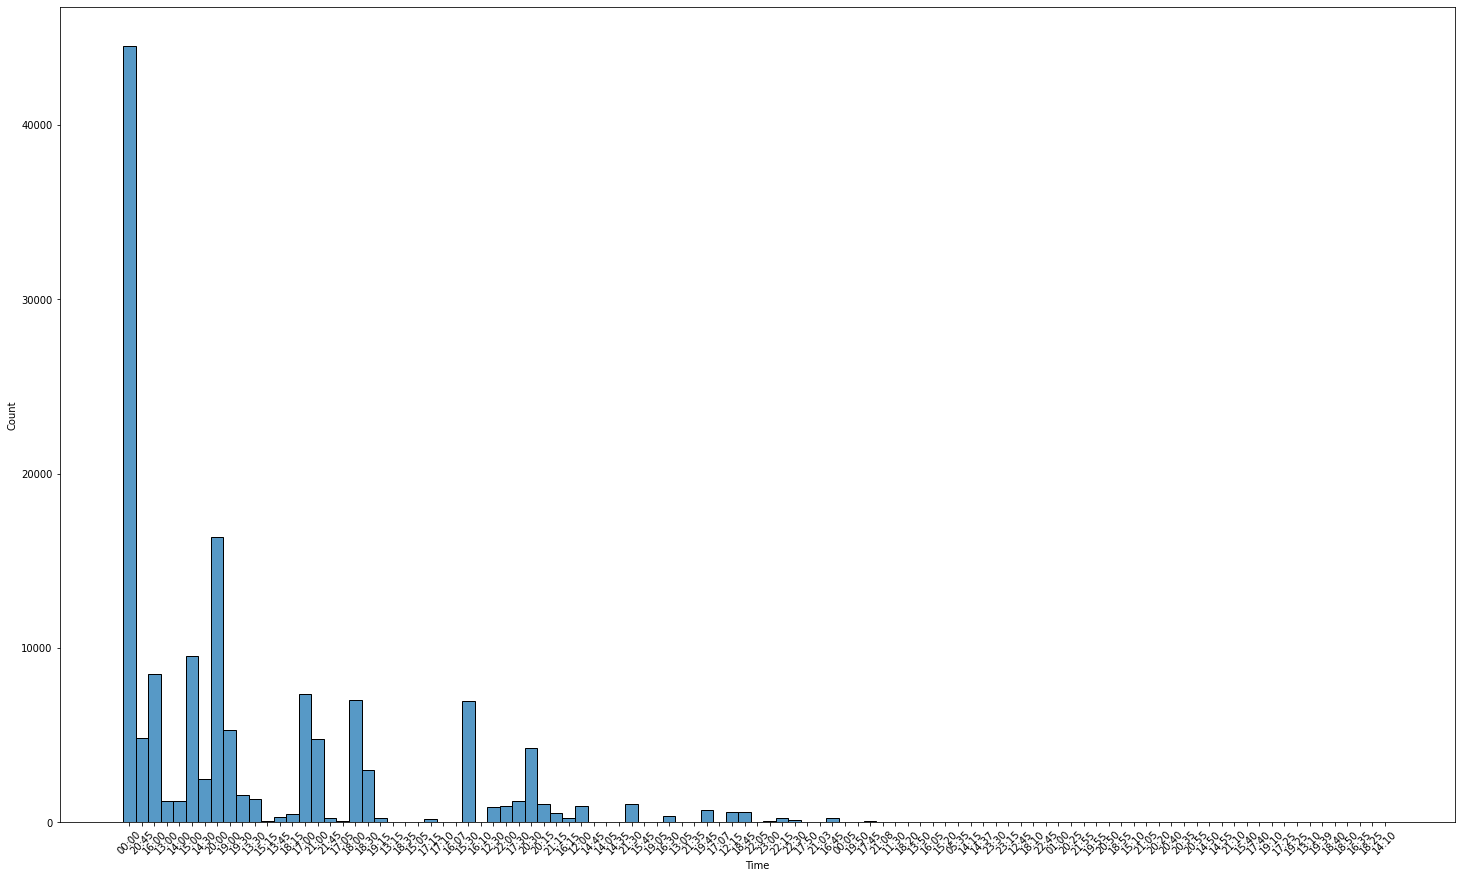

In [19]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Time')
plt.xticks(rotation=45)

#df['Time'].value_counts().sort_index()

In [20]:
df['Time'] = df.loc[~df['Time'].isna(),'Time'].apply(lambda x: int(x.split(':')[0]))
df

/tmp/ipykernel_30820/3271599721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df.loc[~df['Time'].isna(),'Time'].apply(lambda x: int(x.split(':')[0]))


Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
0       championship                                  \r\n          NaN   
1       championship                                  \r\n          NaN   
2       championship                                  \r\n          NaN   
3       championship                                  \r\n          NaN   
4       championship                                  \r\n          NaN   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n          2.0   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n          3.0   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n          1.0   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n          2.0   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n          1.0   

        Home_Red  Away_Yellow  Away_Red              City  Country  \
0            NaN          NaN       NaN           Londres  England   
1            NaN          NaN       NaN           Londres  England   
2            NaN          NaN       NaN           Londres  England   
3            NaN          NaN       NaN           Londres  England   
4            NaN          NaN       NaN           Londres  England   
...          ...          ...       ...               ...      ...   
146501       0.0          2.0       0.0  Nocera Inferiore    Italy   
146502       0.0          3.0       0.0  Nocera Inferiore    Italy   
146503       0.0          3.0       0.0  Nocera Inferiore    Italy   
146504       0.0          3.0       0.0  Nocera Inferiore    Italy   
146505       0.0          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2                    The Den    20146  Natural       NaN       NaN   
3                    The Den    20146  Natural       NaN       NaN   
4                    The Den    20146  Natural       NaN       NaN   
...                      ...      ...      ...       ...       ...   
146501  Stadio San Francesco     9998  Natural      40.0      54.0   
146502  Stadio San Francesco     9998  Natural      40.0      63.0   
146503  Stadio San Francesco     9998  Natural      41.0      59.0   
146504  Stadio San Francesco     9998  Natural      40.0      53.0   
146505  Stadio Sa

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

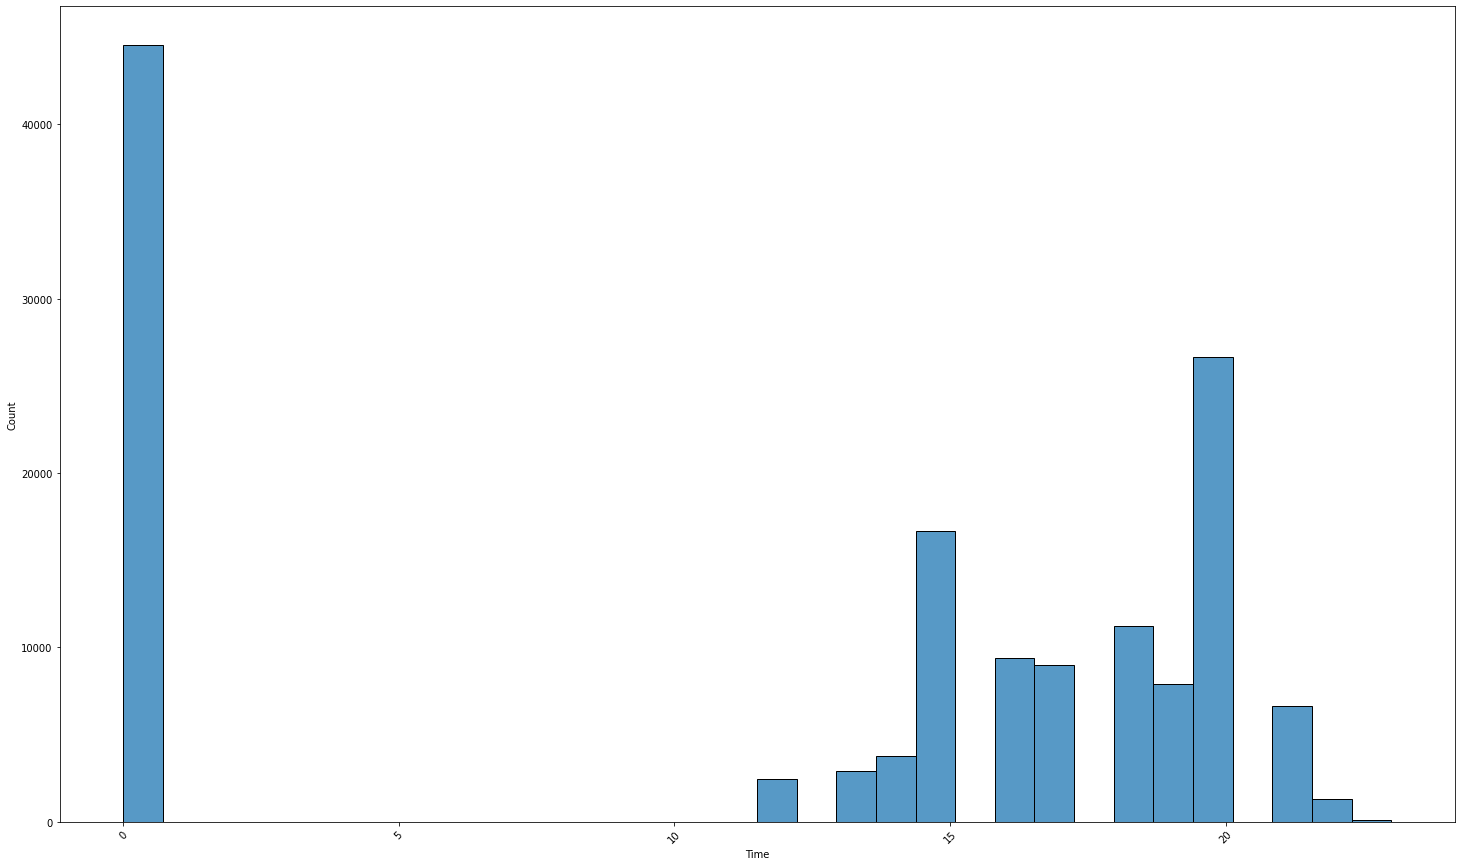

In [21]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Time')
plt.xticks(rotation=45)

#df['Time'].value_counts().sort_index()

In [22]:
df['Time'] = pd.cut(df['Time'], bins=[-1, 11, 16, 20, 24], labels=['Morning', 'Afternoon', 'Evening', 'Night'])
df

/tmp/ipykernel_30820/3833262488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.cut(df['Time'], bins=[-1, 11, 16, 20, 24], labels=['Morning', 'Afternoon', 'Evening', 'Night'])


Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
0       championship                                  \r\n          NaN   
1       championship                                  \r\n          NaN   
2       championship                                  \r\n          NaN   
3       championship                                  \r\n          NaN   
4       championship                                  \r\n          NaN   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n          2.0   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n          3.0   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n          1.0   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n          2.0   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n          1.0   

        Home_Red  Away_Yellow  Away_Red              City  Country  \
0            NaN          NaN       NaN           Londres  England   
1            NaN          NaN       NaN           Londres  England   
2            NaN          NaN       NaN           Londres  England   
3            NaN          NaN       NaN           Londres  England   
4            NaN          NaN       NaN           Londres  England   
...          ...          ...       ...               ...      ...   
146501       0.0          2.0       0.0  Nocera Inferiore    Italy   
146502       0.0          3.0       0.0  Nocera Inferiore    Italy   
146503       0.0          3.0       0.0  Nocera Inferiore    Italy   
146504       0.0          3.0       0.0  Nocera Inferiore    Italy   
146505       0.0          3.0       0.0  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2                    The Den    20146  Natural       NaN       NaN   
3                    The Den    20146  Natural       NaN       NaN   
4                    The Den    20146  Natural       NaN       NaN   
...                      ...      ...      ...       ...       ...   
146501  Stadio San Francesco     9998  Natural      40.0      54.0   
146502  Stadio San Francesco     9998  Natural      40.0      63.0   
146503  Stadio San Francesco     9998  Natural      41.0      59.0   
146504  Stadio San Francesco     9998  Natural      40.0      53.0   
146505  Stadio Sa

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

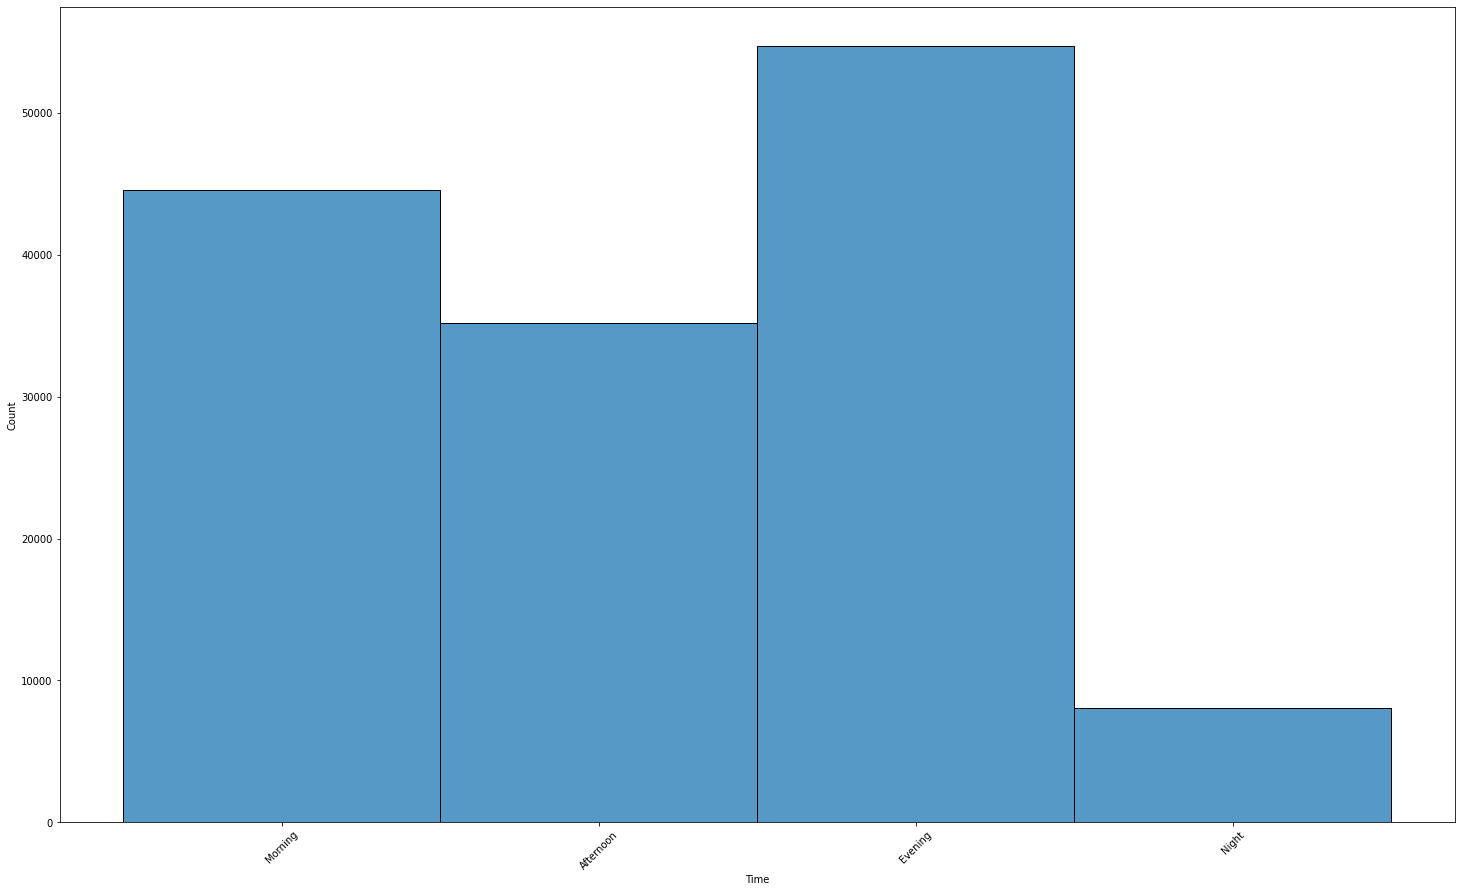

In [23]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Time')
plt.xticks(rotation=45)

#df['Time'].value_counts().sort_index()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

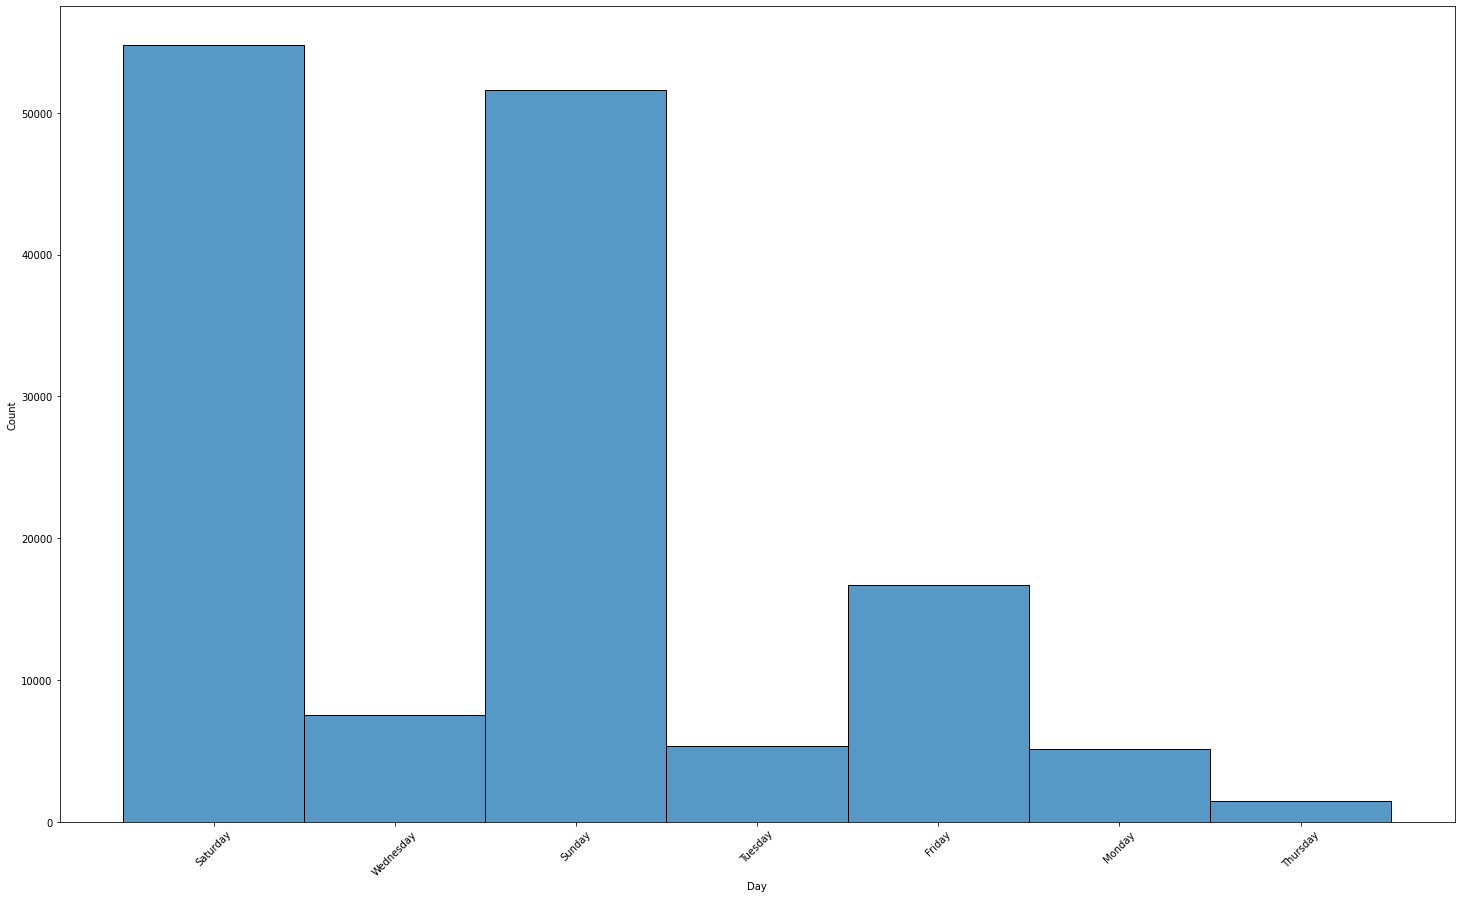

In [24]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Day')
plt.xticks(rotation=45)

#df['Day'].value_counts().sort_index()

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

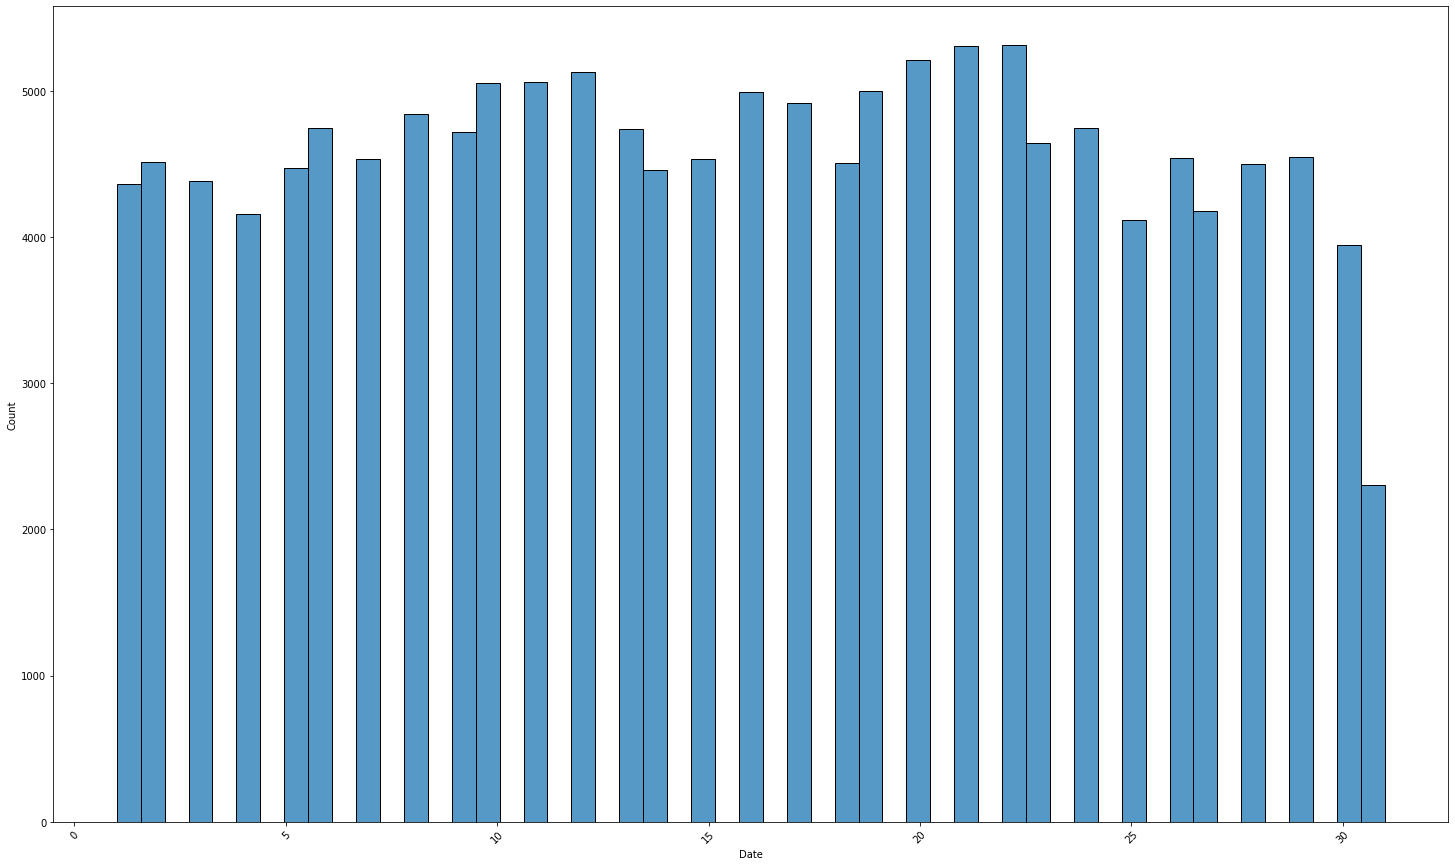

In [25]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Date')
plt.xticks(rotation=45)

#df['Date'].value_counts().sort_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

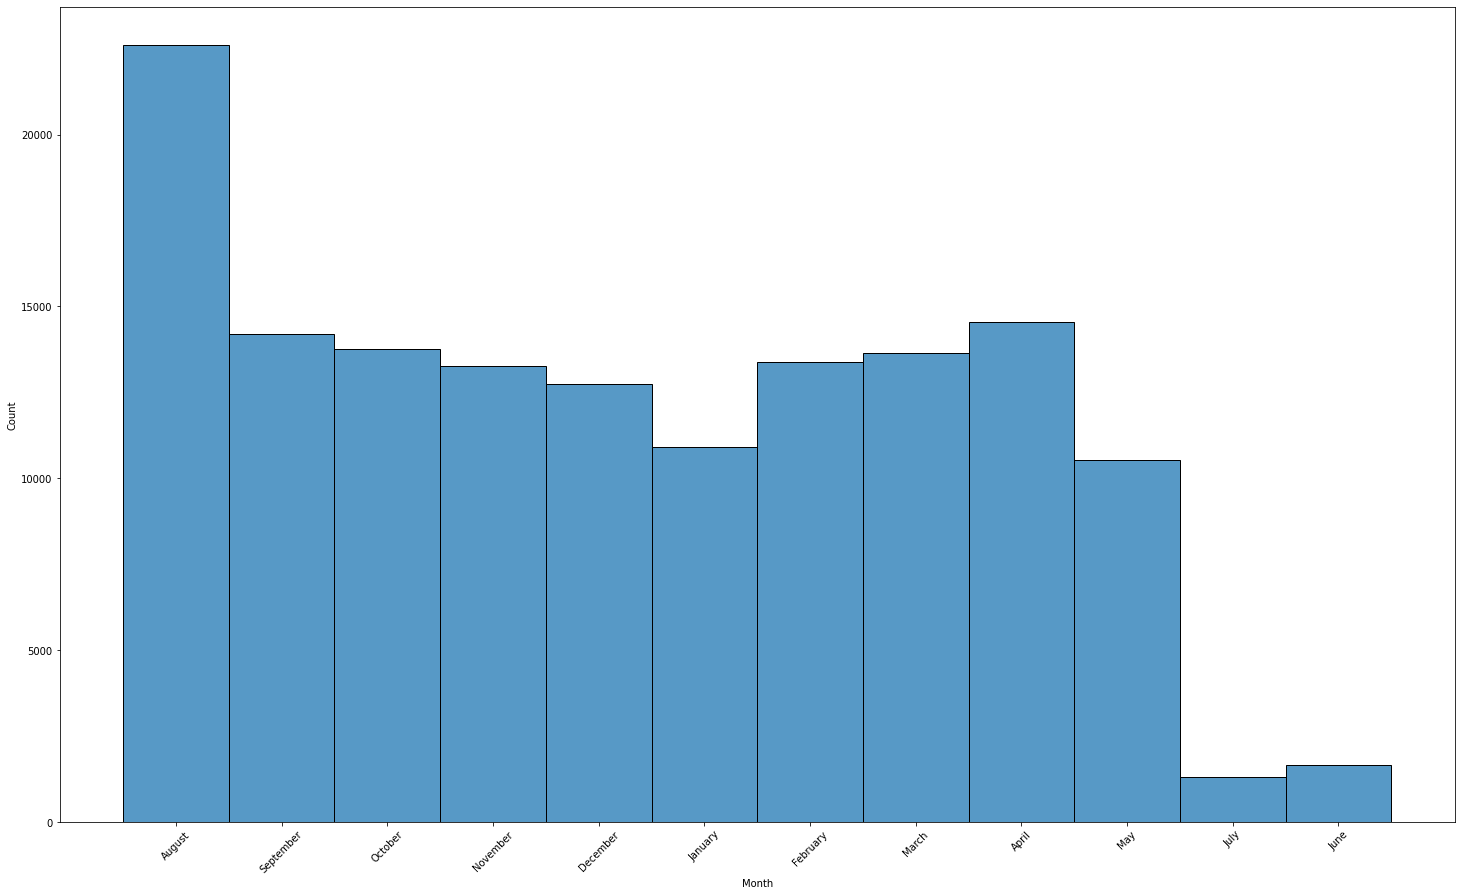

In [26]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Month')
plt.xticks(rotation=45)

#df['Month'].value_counts().sort_index()

(array([1985., 1990., 1995., 2000., 2005., 2010., 2015., 2020., 2025.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

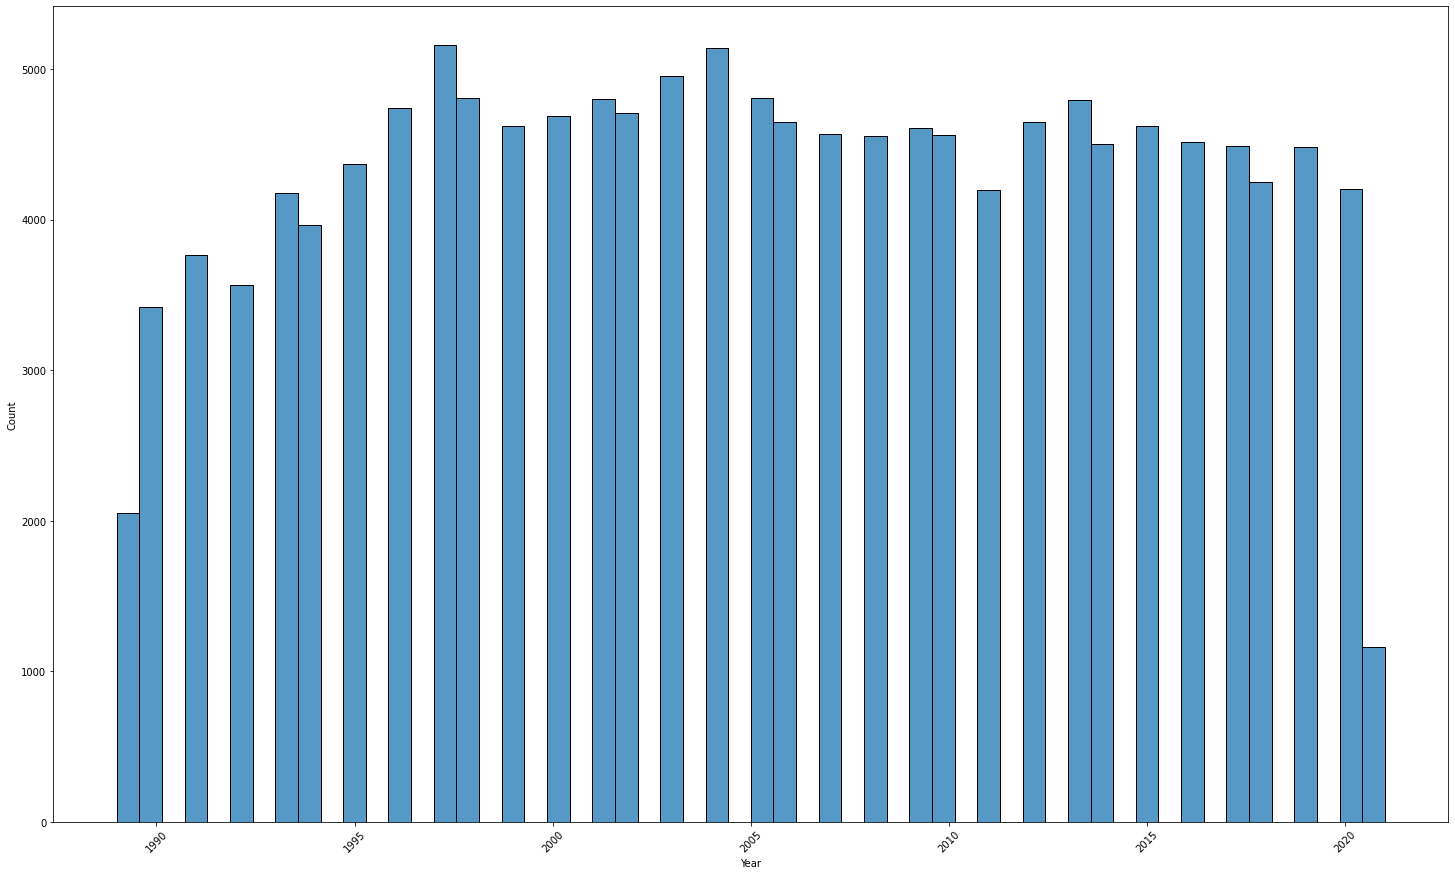

In [27]:
plt.figure(figsize = (25,15))
sns.histplot(data=df, x='Year')
plt.xticks(rotation=45)

#df['Year'].value_counts().sort_index()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146486 entries, 0 to 146505
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         146486 non-null  object  
 1   Away_Team         146486 non-null  object  
 2   Result            146486 non-null  object  
 3   Link              146486 non-null  object  
 4   Season            146486 non-null  float64 
 5   Round             146486 non-null  float64 
 6   League            146486 non-null  object  
 7   Referee           142525 non-null  object  
 8   Home_Yellow       122562 non-null  float64 
 9   Home_Red          122562 non-null  float64 
 10  Away_Yellow       122562 non-null  float64 
 11  Away_Red          122562 non-null  float64 
 12  City              145512 non-null  object  
 13  Country           145512 non-null  object  
 14  Stadium           135679 non-null  object  
 15  Capacity          145512 non-null  object  
 16  Pi

Check Yellow and Red cards and fill null values with the mean.

In [29]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df['Home_Yellow'] = mean_imputer.fit_transform(df['Home_Yellow'].values.reshape(-1, 1))
df['Home_Red'] = mean_imputer.fit_transform(df['Home_Red'].values.reshape(-1, 1))
df['Away_Yellow'] = mean_imputer.fit_transform(df['Away_Yellow'].values.reshape(-1, 1))
df['Away_Red'] = mean_imputer.fit_transform(df['Away_Red'].values.reshape(-1, 1))
df

/tmp/ipykernel_30820/147749765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Home_Yellow'] = mean_imputer.fit_transform(df['Home_Yellow'].values.reshape(-1, 1))
/tmp/ipykernel_30820/147749765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Home_Red'] = mean_imputer.fit_transform(df['Home_Red'].values.reshape(-1, 1))
/tmp/ipykernel_30820/147749765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
0       championship                                  \r\n     1.723568   
1       championship                                  \r\n     1.723568   
2       championship                                  \r\n     1.723568   
3       championship                                  \r\n     1.723568   
4       championship                                  \r\n     1.723568   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n     2.000000   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n     3.000000   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n     1.000000   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n     2.000000   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red              City  Country  \
0       0.067117      2.08971  0.093088           Londres  England   
1       0.067117      2.08971  0.093088           Londres  England   
2       0.067117      2.08971  0.093088           Londres  England   
3       0.067117      2.08971  0.093088           Londres  England   
4       0.067117      2.08971  0.093088           Londres  England   
...          ...          ...       ...               ...      ...   
146501  0.000000      2.00000  0.000000  Nocera Inferiore    Italy   
146502  0.000000      3.00000  0.000000  Nocera Inferiore    Italy   
146503  0.000000      3.00000  0.000000  Nocera Inferiore    Italy   
146504  0.000000      3.00000  0.000000  Nocera Inferiore    Italy   
146505  0.000000      3.00000  0.000000  Nocera Inferiore    Italy   

                     Stadium Capacity    Pitch  Home_ELO  Away_ELO  \
0                    The Den    20146  Natural       NaN       NaN   
1                    The Den    20146  Natural       NaN       NaN   
2                    The Den    20146  Natural       NaN       NaN   
3                    The Den    20146  Natural       NaN       NaN   
4                    The Den    20146  Natural       NaN       NaN   
...                      ...      ...      ...       ...       ...   
146501  Stadio San Francesco     9998  Natural      40.0      54.0   
146502  Stadio San Francesco     9998  Natural      40.0      63.0   
146503  Stadio San Francesco     9998  Natural      41.0      59.0   
146504  Stadio San Francesco     9998  Natural      40.0      53.0   
146505  Stadio Sa

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146486 entries, 0 to 146505
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         146486 non-null  object  
 1   Away_Team         146486 non-null  object  
 2   Result            146486 non-null  object  
 3   Link              146486 non-null  object  
 4   Season            146486 non-null  float64 
 5   Round             146486 non-null  float64 
 6   League            146486 non-null  object  
 7   Referee           142525 non-null  object  
 8   Home_Yellow       146486 non-null  float64 
 9   Home_Red          146486 non-null  float64 
 10  Away_Yellow       146486 non-null  float64 
 11  Away_Red          146486 non-null  float64 
 12  City              145512 non-null  object  
 13  Country           145512 non-null  object  
 14  Stadium           135679 non-null  object  
 15  Capacity          145512 non-null  object  
 16  Pi

Drop the city and country column and replace with a region column that is based on the league column and can easily replace missing values

In [31]:
df['Region'] = df['League']
values_to_update ={
    'Region': {
        'segunda_division': 'Spain',
        'primera_division': 'Spain',
        'serie_b': 'Italy',
        'serie_a': 'Italy',
        'premier_league': 'England',
        'championship': 'England',
        'ligue_1': 'France',
        'ligue_2': 'France',
        '2_liga': 'Germany',
        'bundesliga': 'Germany',
        'eredivisie': 'Netherlands',
        'eerste_divisie': 'Netherlands',
        'primeira_liga': 'Portugal',
        'segunda_liga': 'Portugal'        
        }
}

df = df.replace(values_to_update)
df.drop(columns='City', inplace=True)
df.drop(columns='Country', inplace=True)
df

/tmp/ipykernel_30820/3390428274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Region'] = df['League']


Home_Team           Away_Team Result  \
0       Millwall     Southend United    3-1   
1       Millwall        Derby County    4-1   
2       Millwall  West Bromwich Alb.    2-2   
3       Millwall             Burnley    2-3   
4       Millwall          Luton Town    0-0   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/millwall-fc/sou...  1995.0    1.0   
1       https://www.besoccer.com/match/millwall-fc/der...  1995.0    3.0   
2       https://www.besoccer.com/match/millwall-fc/wes...  1995.0    6.0   
3       https://www.besoccer.com/match/millwall-fc/bur...  1995.0    7.0   
4       https://www.besoccer.com/match/millwall-fc/lut...  1995.0    9.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
0       championship                                  \r\n     1.723568   
1       championship                                  \r\n     1.723568   
2       championship                                  \r\n     1.723568   
3       championship                                  \r\n     1.723568   
4       championship                                  \r\n     1.723568   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n     2.000000   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n     3.000000   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n     1.000000   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n     2.000000   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red               Stadium Capacity  \
0       0.067117      2.08971  0.093088               The Den    20146   
1       0.067117      2.08971  0.093088               The Den    20146   
2       0.067117      2.08971  0.093088               The Den    20146   
3       0.067117      2.08971  0.093088               The Den    20146   
4       0.067117      2.08971  0.093088               The Den    20146   
...          ...          ...       ...                   ...      ...   
146501  0.000000      2.00000  0.000000  Stadio San Francesco     9998   
146502  0.000000      3.00000  0.000000  Stadio San Francesco     9998   
146503  0.000000      3.00000  0.000000  Stadio San Francesco     9998   
146504  0.000000      3.00000  0.000000  Stadio San Francesco     9998   
146505  0.000000      3.00000  0.000000  Stadio San Francesco     9998   

          Pitch  Home_ELO  Away_ELO  Home_Team_Score  Away_Team_Score  \
0       Natural       NaN       NaN                3                1   
1       Natural       NaN       NaN                4                1   
2       Natural       NaN       NaN                2                2   
3       Natural       NaN       NaN                2                3   
4       Natural       NaN       NaN                0                0   
...         ...       ...       ...              ...              ...   
146501  Natural      40.0      54.0                3                1   
146502  Natural      40.0      63.0                2                1   
146503  Natural      41.0      59.0                0                4   
146504  N

Drop stadium column as unlikely to add additional value compared with home team name alone. 

Convert Capacity column to numerical values

In [32]:
def num_filter(x):
    numeric_filter = filter(str.isdigit, str(x))
    numeric_string = "".join(numeric_filter)
    return numeric_string

df['Capacity'] = df['Capacity'].apply(lambda x: num_filter(x))
df['Capacity'].value_counts().sort_index()

          974
1000      155
10000    1854
10134      68
10153     161
         ... 
9779      126
9798       84
9926      105
99787     608
9998       21
Name: Capacity, Length: 433, dtype: int64

ELO values are an important feature that is available in advance of the fixture therefore will drop the rows that do not contain value

In [33]:
df.dropna(subset=['Home_ELO', 'Away_ELO'], inplace=True)
df

Home_Team           Away_Team Result  \
46      Millwall    Rotherham United    0-6   
47      Millwall        Ipswich Town    1-1   
48      Millwall        Grimsby Town    2-0   
49      Millwall  Brighton Hove Alb.    1-0   
50      Millwall             Walsall    0-3   
...          ...                 ...    ...   
146501  Nocerina       Hellas Verona    3-1   
146502  Nocerina              Empoli    2-1   
146503  Nocerina             Reggina    0-4   
146504  Nocerina         AlbinoLeffe    1-0   
146505  Nocerina              Padova    3-0   

                                                     Link  Season  Round  \
46      https://www.besoccer.com/match/millwall-fc/rot...  2003.0    1.0   
47      https://www.besoccer.com/match/millwall-fc/ips...  2003.0    4.0   
48      https://www.besoccer.com/match/millwall-fc/gri...  2003.0    6.0   
49      https://www.besoccer.com/match/millwall-fc/bri...  2003.0    7.0   
50      https://www.besoccer.com/match/millwall-fc/wal...  2003.0   10.0   
...                                                   ...     ...    ...   
146501  https://www.besoccer.com/match/nocerina/hellas...  2012.0   32.0   
146502  https://www.besoccer.com/match/nocerina/empoli...  2012.0   34.0   
146503  https://www.besoccer.com/match/nocerina/reggin...  2012.0   36.0   
146504  https://www.besoccer.com/match/nocerina/uc-alb...  2012.0   39.0   
146505  https://www.besoccer.com/match/nocerina/calcio...  2012.0   41.0   

              League                               Referee  Home_Yellow  \
46      championship           \r\nReferee: Keith Hill\r\n          3.0   
47      championship         \r\nReferee: Steve Baines\r\n          0.0   
48      championship         \r\nReferee: Grant Hegley\r\n          2.0   
49      championship      \r\nReferee: Scott Mathieson\r\n          1.0   
50      championship            \r\nReferee: Lee Cable\r\n          2.0   
...              ...                                   ...          ...   
146501       serie_b      \r\nReferee: Renzo Candussio\r\n          2.0   
146502       serie_b         \r\nReferee: Dino Tommasi\r\n          3.0   
146503       serie_b  \r\nReferee: Gianpaolo Calvarese\r\n          1.0   
146504       serie_b       \r\nReferee: Marco Di Bello\r\n          2.0   
146505       serie_b      \r\nReferee: Maurizio Ciampi\r\n          1.0   

        Home_Red  Away_Yellow  Away_Red               Stadium Capacity  \
46           0.0          1.0       0.0               The Den    20146   
47           0.0          0.0       0.0               The Den    20146   
48           0.0          0.0       0.0               The Den    20146   
49           0.0          2.0       1.0               The Den    20146   
50           0.0          1.0       0.0               The Den    20146   
...          ...          ...       ...                   ...      ...   
146501       0.0          2.0       0.0  Stadio San Francesco     9998   
146502       0.0          3.0       0.0  Stadio San Francesco     9998   
146503       0.0          3.0       0.0  Stadio San Francesco     9998   
146504       0.0          3.0       0.0  Stadio San Francesco     9998   
146505       0.0          3.0       0.0  Stadio San Francesco     9998   

          Pitch  Home_ELO  Away_ELO  Home_Team_Score  Away_Team_Score  \
46      Natural      53.0      46.0                0                6   
47      Natural      53.0      67.0                1                1   
48      Natural      52.0      51.0                2                0   
49      Natural      53.0      41.0                1                0   
50      Natural      53.0      50.0                0                3   
...         ...       ...       ...              ...              ...   
146501  Natural      40.0      54.0                3                1   
146502  Natural      40.0      63.0                2                1   
146503  Natural      41.0      59.0                0                4   
146504  N

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134864 entries, 46 to 146505
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         134864 non-null  object  
 1   Away_Team         134864 non-null  object  
 2   Result            134864 non-null  object  
 3   Link              134864 non-null  object  
 4   Season            134864 non-null  float64 
 5   Round             134864 non-null  float64 
 6   League            134864 non-null  object  
 7   Referee           133265 non-null  object  
 8   Home_Yellow       134864 non-null  float64 
 9   Home_Red          134864 non-null  float64 
 10  Away_Yellow       134864 non-null  float64 
 11  Away_Red          134864 non-null  float64 
 12  Stadium           125401 non-null  object  
 13  Capacity          134864 non-null  object  
 14  Pitch             126461 non-null  object  
 15  Home_ELO          134864 non-null  float64 
 16  A

### Exploratory Data Analysis

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134864 entries, 46 to 146505
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         134864 non-null  object  
 1   Away_Team         134864 non-null  object  
 2   Result            134864 non-null  object  
 3   Link              134864 non-null  object  
 4   Season            134864 non-null  float64 
 5   Round             134864 non-null  float64 
 6   League            134864 non-null  object  
 7   Referee           133265 non-null  object  
 8   Home_Yellow       134864 non-null  float64 
 9   Home_Red          134864 non-null  float64 
 10  Away_Yellow       134864 non-null  float64 
 11  Away_Red          134864 non-null  float64 
 12  Stadium           125401 non-null  object  
 13  Capacity          134864 non-null  object  
 14  Pitch             126461 non-null  object  
 15  Home_ELO          134864 non-null  float64 
 16  A

<AxesSubplot:>

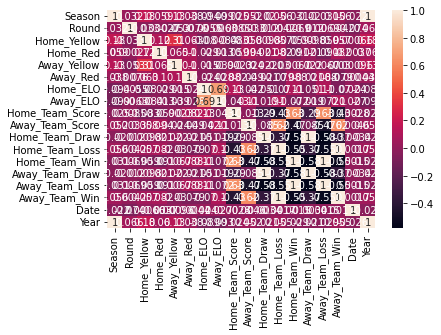

In [36]:
sns.heatmap(df.corr(), annot=True)

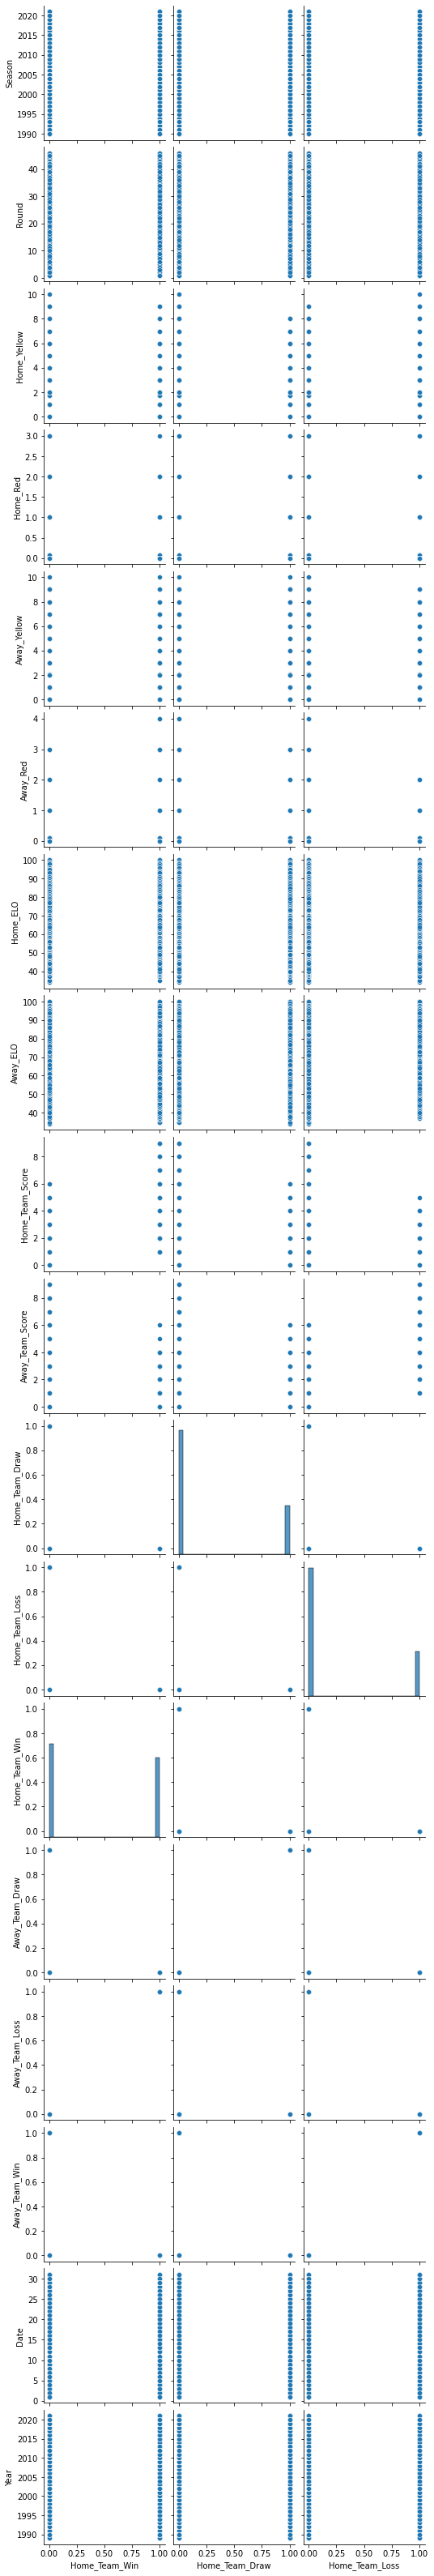

In [37]:
sns.pairplot(data=df, x_vars=['Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'])

/tmp/ipykernel_30820/3904507825.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_win = df.groupby(by=['Region', 'Season'])['Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'].sum().reset_index()


<AxesSubplot:title={'center':'No. Home Team Losses per Season'}, xlabel='Season', ylabel='Home_Team_Loss'>

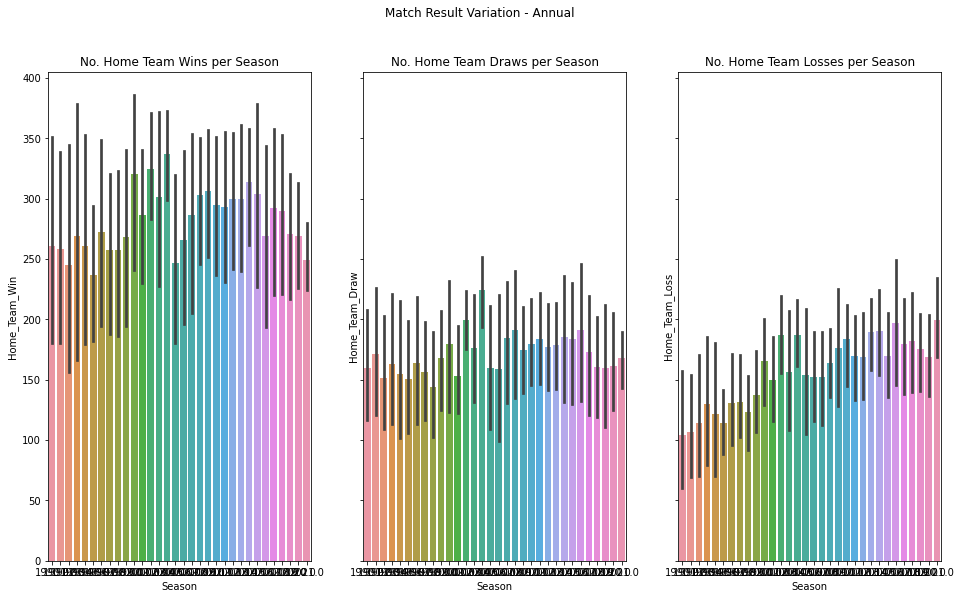

In [38]:
# Win percentage
df_win = df.groupby(by=['Region', 'Season'])['Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'].sum().reset_index()

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 9))
fig.suptitle('Match Result Variation - Annual')
ax[0].set_title('No. Home Team Wins per Season')
ax[1].set_title('No. Home Team Draws per Season')
ax[2].set_title('No. Home Team Losses per Season')
sns.barplot(ax=ax[0], data=df_win, x='Season', y='Home_Team_Win')
sns.barplot(ax=ax[1], data=df_win, x='Season', y='Home_Team_Draw')
sns.barplot(ax=ax[2], data=df_win, x='Season', y='Home_Team_Loss')


/tmp/ipykernel_30820/4176189456.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['Region', 'Season'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Season'>

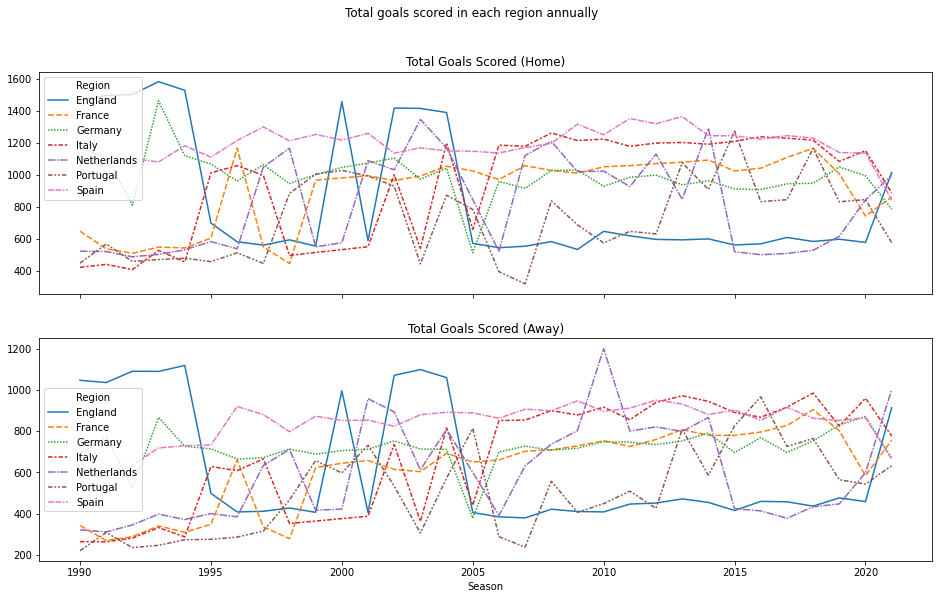

In [39]:
# How many goals were scored in each region?

df_goals = df.groupby(by=['Region', 'Season'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Season', columns='Region')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Season', columns='Region')

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Season'>

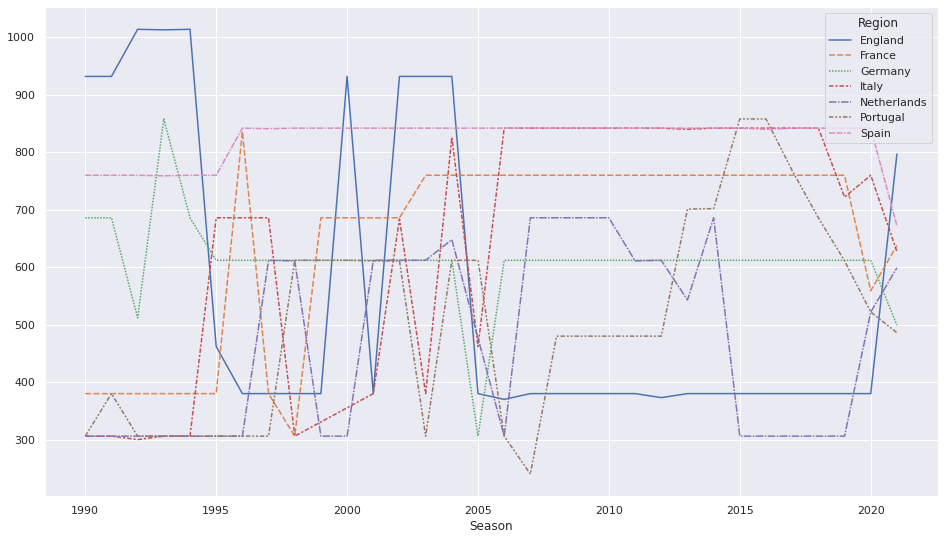

In [40]:
# How many games were played in each region?

df_games = df.groupby(by=['Region', 'Season'])['League'].count().to_frame().reset_index()
df_games = df_games.pivot_table(values='League', index='Season', columns='Region')

sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=df_games)

/tmp/ipykernel_30820/4227497680.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['Region', 'Season'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Season'>

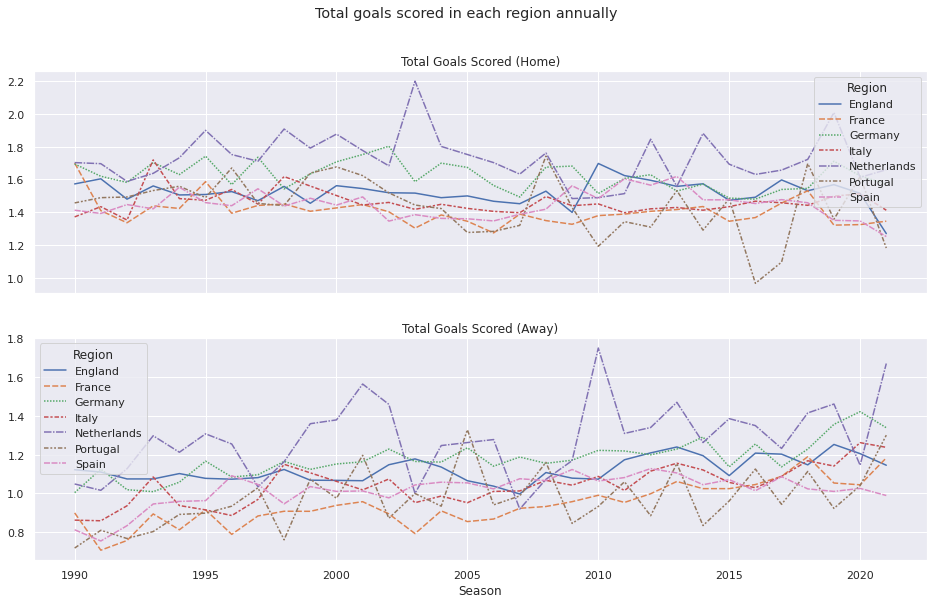

In [41]:
# How many goals are scored per game in each region?

df_goals = df.groupby(by=['Region', 'Season'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Season', columns='Region')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Season', columns='Region')

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

/tmp/ipykernel_30820/1668282431.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['League', 'Season'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Season'>

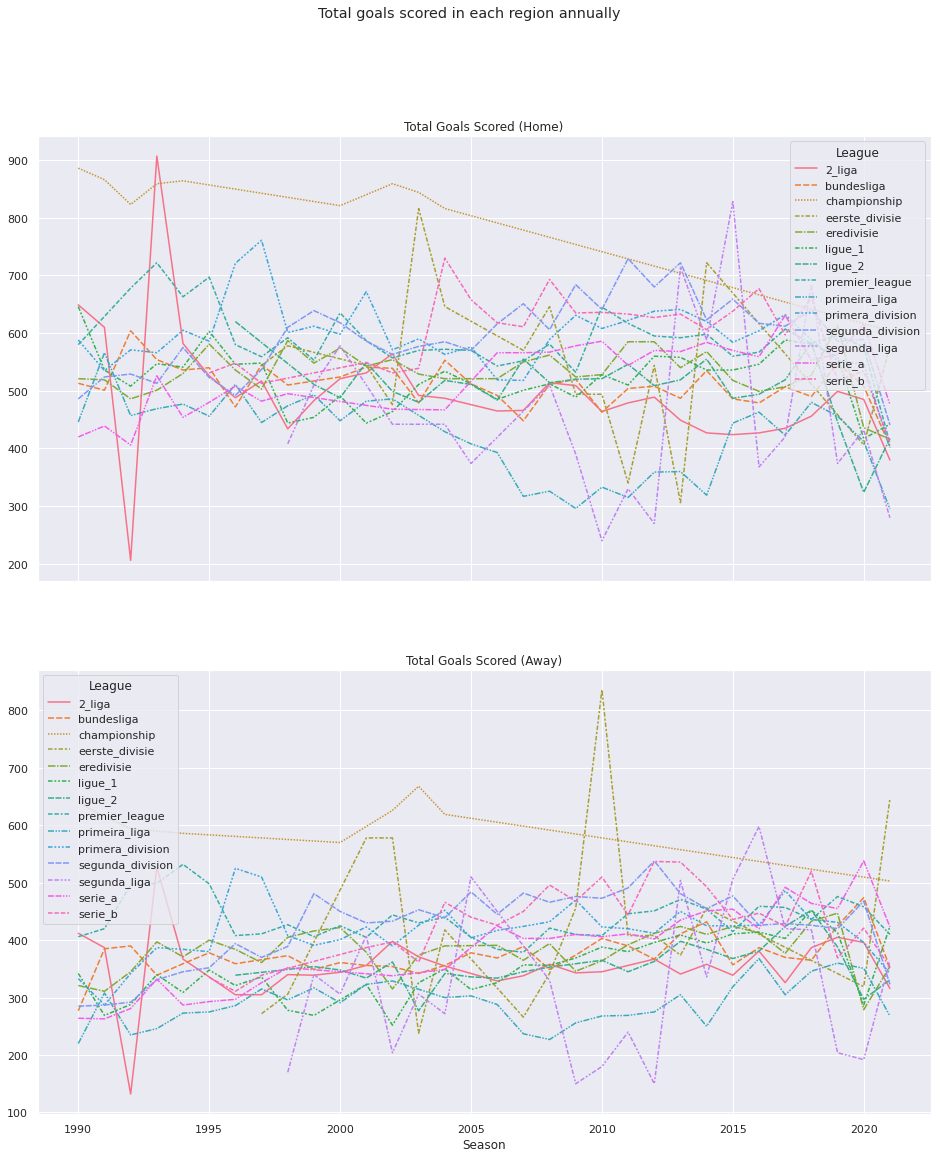

In [42]:
# How many goals were scored in each League?

df_goals = df.groupby(by=['League', 'Season'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Season', columns='League')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Season', columns='League')

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 18))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Season'>

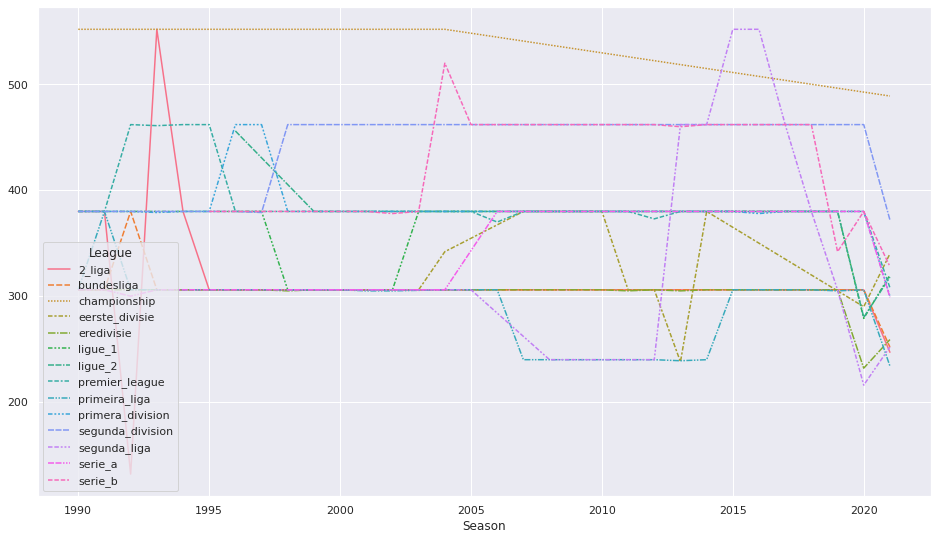

In [43]:
# How many games were played in each league?

df_games = df.groupby(by=['League', 'Season'])['Home_Team_Result'].count().to_frame().reset_index()
df_games = df_games.pivot_table(values='Home_Team_Result', index='Season', columns='League')

sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=df_games)

/tmp/ipykernel_30820/1888964884.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['League', 'Season'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Season'>

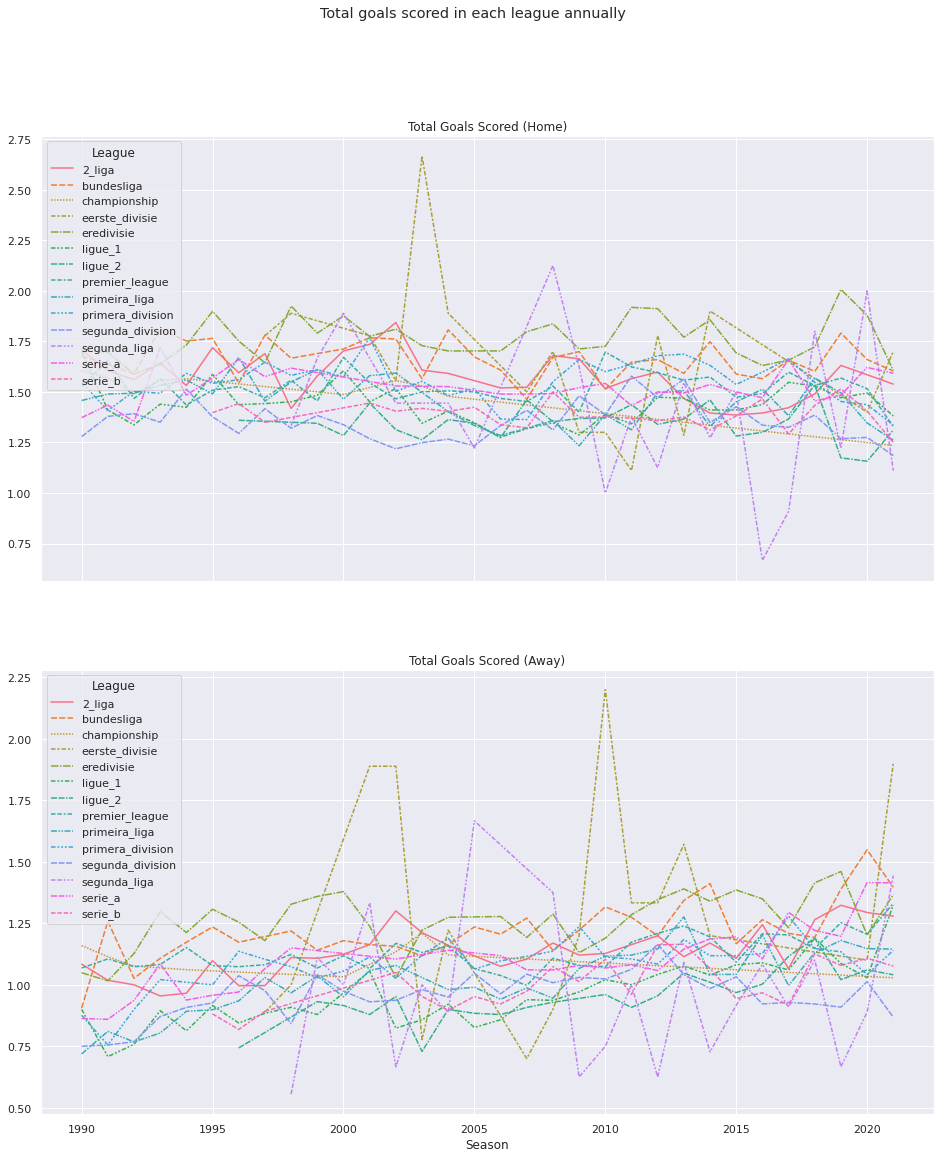

In [44]:
# How many goals are scored per game in each league?

df_goals = df.groupby(by=['League', 'Season'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Season', columns='League')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Season', columns='League')

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 18))
fig.suptitle('Total goals scored in each league annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Season'>

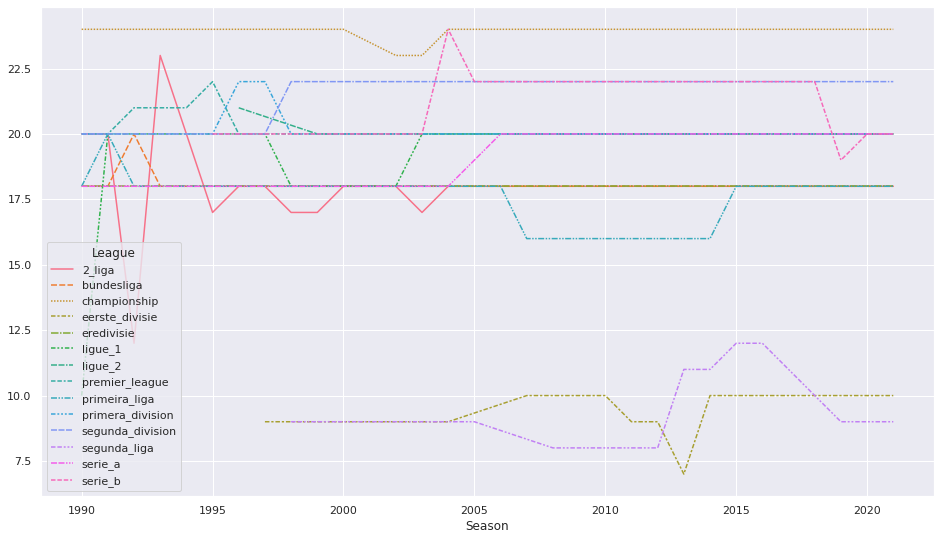

In [45]:
# How many teams played in each league?
teams_year_table = pd.pivot_table(df, values='Home_Team', index='Season', columns='League', aggfunc=lambda x: len(x.unique()))
teams_year_table


sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=teams_year_table)

In [46]:
# Which league has each team appeared in?
df_teams = df.groupby(by=['Home_Team', 'Season'])['League'].min()
df_teams = df_teams.to_frame().reset_index()
df_teams = df_teams.groupby(by=['Home_Team', 'League'])['Season'].count()
df_teams = df_teams.unstack(level=1)
df_teams.fillna(value=0, inplace=True)
df_teams


League           2_liga  bundesliga  championship  eerste_divisie  eredivisie  \
Home_Team                                                                       
1860 München       14.0        10.0           0.0             0.0         0.0   
AC Arezzo           0.0         0.0           0.0             0.0         0.0   
AC Monza            0.0         0.0           0.0             0.0         0.0   
ADO Den Haag        0.0         0.0           0.0             3.0        19.0   
AFC Bournemouth     0.0         0.0           2.0             0.0         0.0   
...                 ...         ...           ...             ...         ...   
Würzburger          2.0         0.0           0.0             0.0         0.0   
Xerez               0.0         0.0           0.0             0.0         0.0   
Zwickau             4.0         0.0           0.0             0.0         0.0   
Écija Balompié      0.0         0.0           0.0             0.0         0.0   
Épinal              0.0         0.0           0.0             0.0         0.0   

League           ligue_1  ligue_2  premier_league  primeira_liga  \
Home_Team                                                          
1860 München         0.0      0.0             0.0            0.0   
AC Arezzo            0.0      0.0             0.0            0.0   
AC Monza             0.0      0.0             0.0            0.0   
ADO Den Haag         0.0      0.0             0.0            0.0   
AFC Bournemouth      0.0      0.0             5.0            0.0   
...                  ...      ...             ...            ...   
Würzburger           0.0      0.0             0.0            0.0   
Xerez                0.0      0.0             0.0            0.0   
Zwickau              0.0      0.0             0.0            0.0   
Écija Balompié       0.0      0.0             0.0            0.0   
Épinal               0.0      1.0             0.0            0.0   

League           primera_division  segunda_division  segunda_liga  serie_a  \
Home_Team                                                                    
1860 München                  0.0               0.0           0.0      0.0   
AC Arezzo                     0.0               0.0           0.0      0.0   
AC Monza                      0.0               0.0           0.0      0.0   
ADO Den Haag                  0.0               0.0           0.0      0.0   
AFC Bournemouth               0.0               0.0           0.0      0.0   
...                           ...               ...           ...      ...   
Würzburger                    0.0               0.0           0.0      0.0   
Xerez                         1.0              14.0           0.0      0.0   
Zwickau                       0.0               0.0           0.0      0.0   
Écija Balompié                0.0               2.0           0.0      0.0   
Épinal                        0.0               0.0           0.0      0.0   

League           serie_b  
Home_Team                 
1860 München         0.0  
AC Arezzo            3.0  
AC Monza             2.0  
ADO Den Haag         0.0  
AFC Bournemouth      0.0  
...                  ...  
Würzburger           0.0  
Xerez                0.0  
Zwickau              0.0  
Écija Balompié       0.0  
Épinal               0.0  

[523 rows x 14 columns]

In [47]:
# How many goals were scored by home and away teams in each league?

df_home_goals = df.groupby(by=['Region', 'League', 'Home_Team', 'Season'])['Home_Team_Score'].sum()
df_home_goals = df_home_goals.to_frame().reset_index()
df_home_goals

Region            League        Home_Team  Season  Home_Team_Score
0     England      championship  AFC Bournemouth  1990.0               30
1     England      championship  AFC Bournemouth  2021.0               40
2     England      championship         Barnsley  1990.0               22
3     England      championship         Barnsley  1991.0               39
4     England      championship         Barnsley  1992.0               26
...       ...               ...              ...     ...              ...
6934    Spain  segunda_division            Xerez  2011.0               32
6935    Spain  segunda_division            Xerez  2012.0               29
6936    Spain  segunda_division            Xerez  2013.0               14
6937    Spain  segunda_division   Écija Balompié  1996.0               22
6938    Spain  segunda_division   Écija Balompié  1997.0               14

[6939 rows x 5 columns]

In [48]:
df_away_goals = df.groupby(by=['Region', 'League', 'Away_Team', 'Season'])['Away_Team_Score'].sum()
df_away_goals = df_away_goals.to_frame().reset_index()
df_away_goals

Region            League        Away_Team  Season  Away_Team_Score
0     England      championship  AFC Bournemouth  1990.0               27
1     England      championship  AFC Bournemouth  2021.0               26
2     England      championship         Barnsley  1990.0               27
3     England      championship         Barnsley  1991.0               24
4     England      championship         Barnsley  1992.0               19
...       ...               ...              ...     ...              ...
6934    Spain  segunda_division            Xerez  2011.0               28
6935    Spain  segunda_division            Xerez  2012.0               21
6936    Spain  segunda_division            Xerez  2013.0               24
6937    Spain  segunda_division   Écija Balompié  1996.0               12
6938    Spain  segunda_division   Écija Balompié  1997.0               13

[6939 rows x 5 columns]

In [49]:
# Who is the most (and least) successful team in each league?
df_home = df.loc[:,['Home_Team', 'Home_Team_Score', 'Away_Team_Score', 'League', 'Region', 'Season', 'Round']]
df_home.rename(columns={'Home_Team': 'Team', 'Home_Team_Score': 'GS', 'Away_Team_Score': 'GC'}, inplace=True)
df_away = df.loc[:,['Away_Team', 'Away_Team_Score', 'Home_Team_Score', 'League', 'Region', 'Season', 'Round']]
df_away.rename(columns={'Away_Team': 'Team', 'Away_Team_Score': 'GS', 'Home_Team_Score': 'GC'}, inplace=True)
df_points = pd.concat([df_home, df_away]).reset_index(drop=True)

def win_func(x):
    if x['GS'] > x['GC']:
        return 3
    elif x['GS'] == x['GC']:
        return 1
    else:
        return 0

df_points['Result'] = df_points.apply(lambda row: win_func(row), axis=1)
df_points

Team  GS  GC        League   Region  Season  Round  Result
0            Millwall   0   6  championship  England  2003.0    1.0       0
1            Millwall   1   1  championship  England  2003.0    4.0       1
2            Millwall   2   0  championship  England  2003.0    6.0       3
3            Millwall   1   0  championship  England  2003.0    7.0       3
4            Millwall   0   3  championship  England  2003.0   10.0       0
...               ...  ..  ..           ...      ...     ...    ...     ...
269723  Hellas Verona   1   3       serie_b    Italy  2012.0   32.0       0
269724         Empoli   1   2       serie_b    Italy  2012.0   34.0       0
269725        Reggina   4   0       serie_b    Italy  2012.0   36.0       3
269726    AlbinoLeffe   0   1       serie_b    Italy  2012.0   39.0       0
269727         Padova   0   3       serie_b    Italy  2012.0   41.0       0

[269728 rows x 8 columns]

Bayern München       19
Porto                19
Barcelona            17
Juventus             15
Ajax                 14
                     ..
Napoli                1
Wolfsburg             1
B. Leverkusen         1
Arminia Bielefeld     1
Espanyol              1
Name: idxmax, Length: 142, dtype: int64

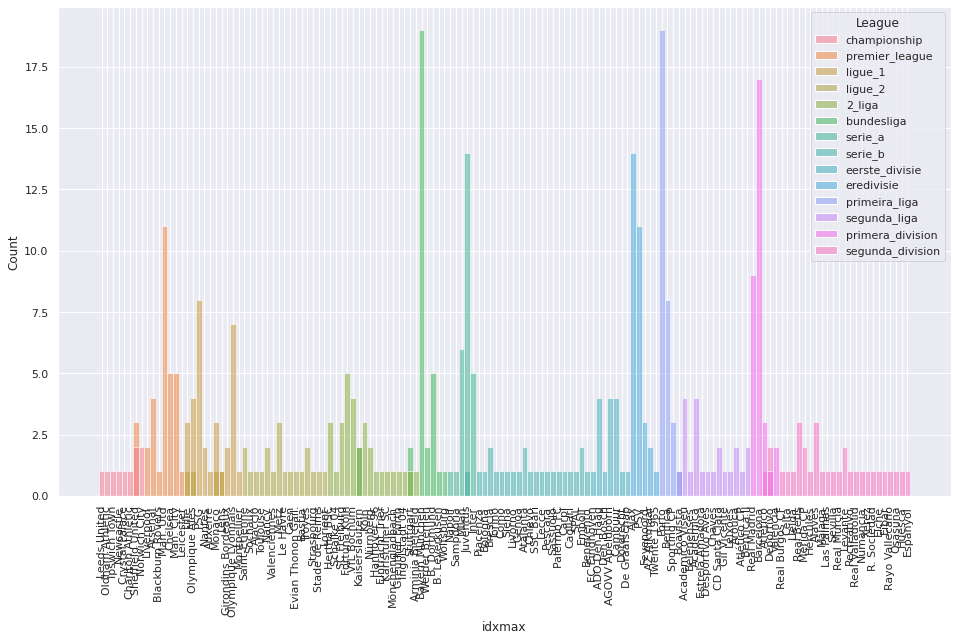

In [50]:
df_result = df_points.groupby(by=['Region', 'League', 'Team', 'Season'])['Result'].sum().to_frame().reset_index().set_index('Team')
df_result = df_result.groupby(by=['Region', 'League', 'Season'])['Result'].agg(['idxmin', 'min', 'idxmax', 'max'])

sns.histplot(data=df_result, x='idxmax', hue='League')
plt.xticks(rotation=90)

df_result['idxmax'].value_counts()


<AxesSubplot:>

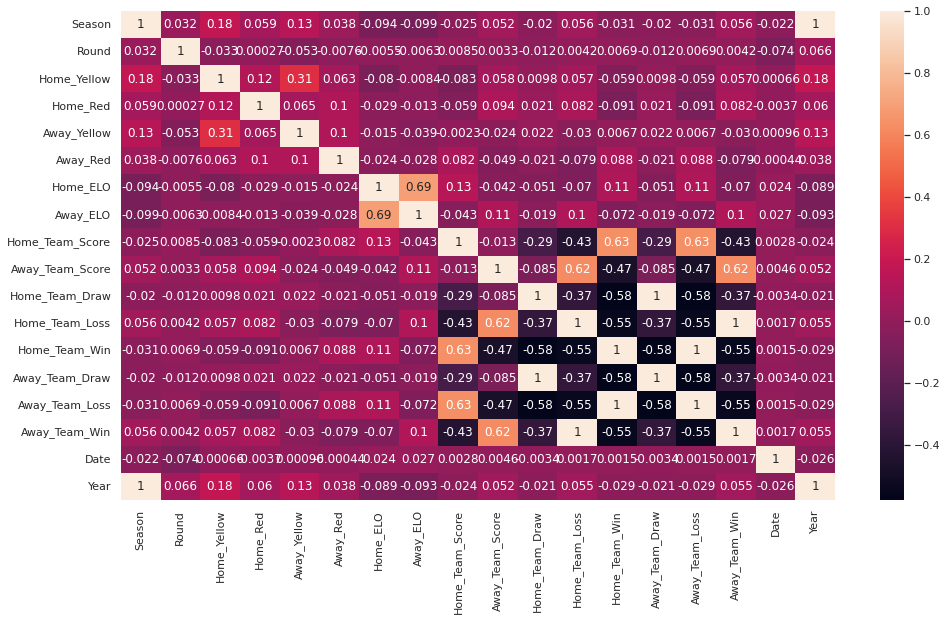

In [51]:
sns.heatmap(df.corr(), annot=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134864 entries, 46 to 146505
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         134864 non-null  object  
 1   Away_Team         134864 non-null  object  
 2   Result            134864 non-null  object  
 3   Link              134864 non-null  object  
 4   Season            134864 non-null  float64 
 5   Round             134864 non-null  float64 
 6   League            134864 non-null  object  
 7   Referee           133265 non-null  object  
 8   Home_Yellow       134864 non-null  float64 
 9   Home_Red          134864 non-null  float64 
 10  Away_Yellow       134864 non-null  float64 
 11  Away_Red          134864 non-null  float64 
 12  Stadium           125401 non-null  object  
 13  Capacity          134864 non-null  object  
 14  Pitch             126461 non-null  object  
 15  Home_ELO          134864 non-null  float64 
 16  A

#### Conclusions:
- Home Team Score score appears to be the strongest predictor of a win
- Team name could be a reasonably strong predictor as there appear to be clusters of highly successful teams in each league over the years
- Team ELO is a better predictor than most other features
- Generally most features don't appear to have very strong correlation with the likelihood of winning
- Slight negative correlation between No. red cards for home team and No. win and vice versa.



# Additional Feature Engineering

### Compound Feature Engineering

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134864 entries, 46 to 146505
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Home_Team         134864 non-null  object  
 1   Away_Team         134864 non-null  object  
 2   Result            134864 non-null  object  
 3   Link              134864 non-null  object  
 4   Season            134864 non-null  float64 
 5   Round             134864 non-null  float64 
 6   League            134864 non-null  object  
 7   Referee           133265 non-null  object  
 8   Home_Yellow       134864 non-null  float64 
 9   Home_Red          134864 non-null  float64 
 10  Away_Yellow       134864 non-null  float64 
 11  Away_Red          134864 non-null  float64 
 12  Stadium           125401 non-null  object  
 13  Capacity          134864 non-null  object  
 14  Pitch             126461 non-null  object  
 15  Home_ELO          134864 non-null  float64 
 16  A

In [54]:
df.dropna(inplace=True)
df.sort_values(by=['Season', 'Round'], inplace=True)
df.reset_index(inplace=True, drop=True)

Create cumulative goals, wins, losses and draws features per season for each team and determine the cummulative win-loss ratio also

In [55]:
df_rt = df.groupby(by=['Home_Team', 'Season'])['Home_Team_Score', 'Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'].cumsum()
df_rt.rename(columns={
    'Home_Team_Score': 'Home_Team_Score_Total',
    'Home_Team_Win': 'Home_Team_Win_Total',
    'Home_Team_Draw': 'Home_Team_Draw_Total',
    'Home_Team_Loss': 'Home_Team_Loss_Total'
    },
    inplace=True)

df = df.join(df_rt)

df_rt = df.groupby(by=['Away_Team', 'Season'])['Away_Team_Score', 'Away_Team_Win', 'Away_Team_Draw', 'Away_Team_Loss'].cumsum()
df_rt.rename(columns={
    'Away_Team_Score': 'Away_Team_Score_Total',
    'Away_Team_Win': 'Away_Team_Win_Total',
    'Away_Team_Draw': 'Away_Team_Draw_Total',
    'Away_Team_Loss': 'Away_Team_Loss_Total'
    },
    inplace=True)

df = df.join(df_rt)
df

/tmp/ipykernel_30820/2208042218.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_rt = df.groupby(by=['Home_Team', 'Season'])['Home_Team_Score', 'Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'].cumsum()
/tmp/ipykernel_30820/2208042218.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_rt = df.groupby(by=['Away_Team', 'Season'])['Away_Team_Score', 'Away_Team_Win', 'Away_Team_Draw', 'Away_Team_Loss'].cumsum()


Home_Team           Away_Team Result  \
0             Portsmouth          Stoke City    0-0   
1             Stoke City            West Ham    1-1   
2               Barnsley  Brighton Hove Alb.    1-0   
3          Middlesbrough              Wolves    4-2   
4       Sheffield United        Ipswich Town    2-0   
...                  ...                 ...    ...   
121441          Jong PSV           Excelsior    1-6   
121442           TOP Oss       Helmond Sport    1-2   
121443        SC Telstar         FC Volendam    2-2   
121444         Jong Ajax             Roda JC    0-4   
121445       Almere City      MVV Maastricht    0-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/portsmouth/stok...  1990.0    1.0   
1       https://www.besoccer.com/match/stoke-city/west...  1990.0    1.0   
2       https://www.besoccer.com/match/barnsley-fc/bri...  1990.0    1.0   
3       https://www.besoccer.com/match/middlesbrough-f...  1990.0    1.0   
4       https://www.besoccer.com/match/sheffield-unite...  1990.0    1.0   
...                                                   ...     ...    ...   
121441  https://www.besoccer.com/match/jong-psv/excels...  2021.0   34.0   
121442  https://www.besoccer.com/match/fc-oss/helmond-...  2021.0   34.0   
121443  https://www.besoccer.com/match/stormvogels-tel...  2021.0   34.0   
121444  https://www.besoccer.com/match/jong-ajax/roda-...  2021.0   34.0   
121445  https://www.besoccer.com/match/almere-city/mvv...  2021.0   34.0   

                League                           Referee  Home_Yellow  \
0         championship                              \r\n     1.723568   
1         championship                              \r\n     1.723568   
2         championship                              \r\n     1.723568   
3         championship                              \r\n     1.723568   
4         championship                              \r\n     1.723568   
...                ...                               ...          ...   
121441  eerste_divisie        \r\nReferee: Teuben S.\r\n     2.000000   
121442  eerste_divisie  \r\nReferee: van der Laan J.\r\n     4.000000   
121443  eerste_divisie     \r\nReferee: Gozubuyuk S.\r\n     2.000000   
121444  eerste_divisie         \r\nReferee: Blank E.\r\n     1.000000   
121445  eerste_divisie       \r\nReferee: Ruperti C.\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red                      Stadium Capacity  \
0       0.067117      2.08971  0.093088                 Fratton Park    20821   
1       0.067117      2.08971  0.093088               bet365 Stadium    28383   
2       0.067117      2.08971  0.093088              Oakwell Stadium    23009   
3       0.067117      2.08971  0.093088            Riverside Stadium    34988   
4       0.067117      2.08971  0.093088                 Bramall Lane    32702   
...          ...          ...       ...                          ...      ...   
121441  0.000000      2.00000  0.000000     Sportcomplex De Herdgang     2500   
121442  0.000000      4.00000  1.000000         Frans Heesen Stadion     4700   
121443  0.000000      1.00000  0.000000           TATA Steel Stadion     3625   
121444  0.000000      1.00000  0.000000        Sportpark De Toekomst     5000   
121445  0.000000      2.00000  0.000000  Mitsubishi Forklift-Stadion     2500   

                    Pitch  Home_ELO  Away_ELO  Home_Team_Score  \
0                 Natural      55.0      55.0                0   
1                 Natural      55.0      69.0                1   
2                 Natural      54.0      55.0                1   
3                 Natural      58.0      57.0                4   
4                 Natural      53.0      61.0                2   
...                   ...       ...       ...              ...   
121441            Natural      52.0      60.0                1   
121442            Natural      45.0      45.0                1 

In [56]:
# Modify total features to exclude outcome of current fixture

df['Home_Team_Score_Total'] = df['Home_Team_Score_Total'] - df['Home_Team_Score']
df['Home_Team_Win_Total'] = df['Home_Team_Win_Total'] - df['Home_Team_Win']
df['Home_Team_Draw_Total'] = df['Home_Team_Draw_Total'] - df['Home_Team_Draw']
df['Home_Team_Loss_Total'] = df['Home_Team_Loss_Total'] - df['Home_Team_Loss']

df['Away_Team_Score_Total'] = df['Away_Team_Score_Total'] - df['Away_Team_Score']
df['Away_Team_Win_Total'] = df['Away_Team_Win_Total'] - df['Away_Team_Win']
df['Away_Team_Draw_Total'] = df['Away_Team_Draw_Total'] - df['Away_Team_Draw']
df['Away_Team_Loss_Total'] = df['Away_Team_Loss_Total'] - df['Away_Team_Loss']

df

Home_Team           Away_Team Result  \
0             Portsmouth          Stoke City    0-0   
1             Stoke City            West Ham    1-1   
2               Barnsley  Brighton Hove Alb.    1-0   
3          Middlesbrough              Wolves    4-2   
4       Sheffield United        Ipswich Town    2-0   
...                  ...                 ...    ...   
121441          Jong PSV           Excelsior    1-6   
121442           TOP Oss       Helmond Sport    1-2   
121443        SC Telstar         FC Volendam    2-2   
121444         Jong Ajax             Roda JC    0-4   
121445       Almere City      MVV Maastricht    0-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/portsmouth/stok...  1990.0    1.0   
1       https://www.besoccer.com/match/stoke-city/west...  1990.0    1.0   
2       https://www.besoccer.com/match/barnsley-fc/bri...  1990.0    1.0   
3       https://www.besoccer.com/match/middlesbrough-f...  1990.0    1.0   
4       https://www.besoccer.com/match/sheffield-unite...  1990.0    1.0   
...                                                   ...     ...    ...   
121441  https://www.besoccer.com/match/jong-psv/excels...  2021.0   34.0   
121442  https://www.besoccer.com/match/fc-oss/helmond-...  2021.0   34.0   
121443  https://www.besoccer.com/match/stormvogels-tel...  2021.0   34.0   
121444  https://www.besoccer.com/match/jong-ajax/roda-...  2021.0   34.0   
121445  https://www.besoccer.com/match/almere-city/mvv...  2021.0   34.0   

                League                           Referee  Home_Yellow  \
0         championship                              \r\n     1.723568   
1         championship                              \r\n     1.723568   
2         championship                              \r\n     1.723568   
3         championship                              \r\n     1.723568   
4         championship                              \r\n     1.723568   
...                ...                               ...          ...   
121441  eerste_divisie        \r\nReferee: Teuben S.\r\n     2.000000   
121442  eerste_divisie  \r\nReferee: van der Laan J.\r\n     4.000000   
121443  eerste_divisie     \r\nReferee: Gozubuyuk S.\r\n     2.000000   
121444  eerste_divisie         \r\nReferee: Blank E.\r\n     1.000000   
121445  eerste_divisie       \r\nReferee: Ruperti C.\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red                      Stadium Capacity  \
0       0.067117      2.08971  0.093088                 Fratton Park    20821   
1       0.067117      2.08971  0.093088               bet365 Stadium    28383   
2       0.067117      2.08971  0.093088              Oakwell Stadium    23009   
3       0.067117      2.08971  0.093088            Riverside Stadium    34988   
4       0.067117      2.08971  0.093088                 Bramall Lane    32702   
...          ...          ...       ...                          ...      ...   
121441  0.000000      2.00000  0.000000     Sportcomplex De Herdgang     2500   
121442  0.000000      4.00000  1.000000         Frans Heesen Stadion     4700   
121443  0.000000      1.00000  0.000000           TATA Steel Stadion     3625   
121444  0.000000      1.00000  0.000000        Sportpark De Toekomst     5000   
121445  0.000000      2.00000  0.000000  Mitsubishi Forklift-Stadion     2500   

                    Pitch  Home_ELO  Away_ELO  Home_Team_Score  \
0                 Natural      55.0      55.0                0   
1                 Natural      55.0      69.0                1   
2                 Natural      54.0      55.0                1   
3                 Natural      58.0      57.0                4   
4                 Natural      53.0      61.0                2   
...                   ...       ...       ...              ...   
121441            Natural      52.0      60.0                1   
121442            Natural      45.0      45.0                1 

In [57]:
df['Home_Win_Loss_Ratio'] = df['Home_Team_Win_Total']/df['Home_Team_Loss_Total']
df['Home_Win_Loss_Ratio'] = df['Home_Win_Loss_Ratio'].replace([np.inf, -np.inf], 100)
df['Home_Win_Loss_Ratio'] = df['Home_Win_Loss_Ratio'].replace(np.nan, 0)

df['Home_Win_Ratio'] = df['Home_Team_Win_Total']/(df['Home_Team_Draw_Total'] + df['Home_Team_Loss_Total'])
df['Home_Win_Ratio'] = df['Home_Win_Ratio'].replace([np.inf, -np.inf], 100)
df['Home_Win_Ratio'] = df['Home_Win_Ratio'].replace(np.nan, 0)

df['Home_Draw_Ratio'] = df['Home_Team_Draw_Total']/(df['Home_Team_Win_Total'] + df['Home_Team_Loss_Total'])
df['Home_Draw_Ratio'] = df['Home_Draw_Ratio'].replace([np.inf, -np.inf], 100)
df['Home_Draw_Ratio'] = df['Home_Draw_Ratio'].replace(np.nan, 0)

df['Home_Loss_Ratio'] = df['Home_Team_Loss_Total']/(df['Home_Team_Draw_Total'] + df['Home_Team_Win_Total'])
df['Home_Loss_Ratio'] = df['Home_Loss_Ratio'].replace([np.inf, -np.inf], 100)
df['Home_Loss_Ratio'] = df['Home_Loss_Ratio'].replace(np.nan, 0)


df['Away_Win_Loss_Ratio'] = df['Away_Team_Win_Total']/df['Away_Team_Loss_Total']
df['Away_Win_Loss_Ratio'] = df['Away_Win_Loss_Ratio'].replace([np.inf, -np.inf], 100)
df['Away_Win_Loss_Ratio'] = df['Away_Win_Loss_Ratio'].replace(np.nan, 0)

df['Away_Win_Ratio'] = df['Away_Team_Win_Total']/(df['Away_Team_Draw_Total'] + df['Away_Team_Loss_Total'])
df['Away_Win_Ratio'] = df['Away_Win_Ratio'].replace([np.inf, -np.inf], 100)
df['Away_Win_Ratio'] = df['Away_Win_Ratio'].replace(np.nan, 0)

df['Away_Draw_Ratio'] = df['Away_Team_Draw_Total']/(df['Away_Team_Win_Total'] + df['Away_Team_Loss_Total'])
df['Away_Draw_Ratio'] = df['Away_Draw_Ratio'].replace([np.inf, -np.inf], 100)
df['Away_Draw_Ratio'] = df['Away_Draw_Ratio'].replace(np.nan, 0)

df['Away_Loss_Ratio'] = df['Away_Team_Loss_Total']/(df['Away_Team_Draw_Total'] + df['Away_Team_Win_Total'])
df['Away_Loss_Ratio'] = df['Away_Loss_Ratio'].replace([np.inf, -np.inf], 100)
df['Away_Loss_Ratio'] = df['Away_Loss_Ratio'].replace(np.nan, 0)

df


Home_Team           Away_Team Result  \
0             Portsmouth          Stoke City    0-0   
1             Stoke City            West Ham    1-1   
2               Barnsley  Brighton Hove Alb.    1-0   
3          Middlesbrough              Wolves    4-2   
4       Sheffield United        Ipswich Town    2-0   
...                  ...                 ...    ...   
121441          Jong PSV           Excelsior    1-6   
121442           TOP Oss       Helmond Sport    1-2   
121443        SC Telstar         FC Volendam    2-2   
121444         Jong Ajax             Roda JC    0-4   
121445       Almere City      MVV Maastricht    0-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/portsmouth/stok...  1990.0    1.0   
1       https://www.besoccer.com/match/stoke-city/west...  1990.0    1.0   
2       https://www.besoccer.com/match/barnsley-fc/bri...  1990.0    1.0   
3       https://www.besoccer.com/match/middlesbrough-f...  1990.0    1.0   
4       https://www.besoccer.com/match/sheffield-unite...  1990.0    1.0   
...                                                   ...     ...    ...   
121441  https://www.besoccer.com/match/jong-psv/excels...  2021.0   34.0   
121442  https://www.besoccer.com/match/fc-oss/helmond-...  2021.0   34.0   
121443  https://www.besoccer.com/match/stormvogels-tel...  2021.0   34.0   
121444  https://www.besoccer.com/match/jong-ajax/roda-...  2021.0   34.0   
121445  https://www.besoccer.com/match/almere-city/mvv...  2021.0   34.0   

                League                           Referee  Home_Yellow  \
0         championship                              \r\n     1.723568   
1         championship                              \r\n     1.723568   
2         championship                              \r\n     1.723568   
3         championship                              \r\n     1.723568   
4         championship                              \r\n     1.723568   
...                ...                               ...          ...   
121441  eerste_divisie        \r\nReferee: Teuben S.\r\n     2.000000   
121442  eerste_divisie  \r\nReferee: van der Laan J.\r\n     4.000000   
121443  eerste_divisie     \r\nReferee: Gozubuyuk S.\r\n     2.000000   
121444  eerste_divisie         \r\nReferee: Blank E.\r\n     1.000000   
121445  eerste_divisie       \r\nReferee: Ruperti C.\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red                      Stadium Capacity  \
0       0.067117      2.08971  0.093088                 Fratton Park    20821   
1       0.067117      2.08971  0.093088               bet365 Stadium    28383   
2       0.067117      2.08971  0.093088              Oakwell Stadium    23009   
3       0.067117      2.08971  0.093088            Riverside Stadium    34988   
4       0.067117      2.08971  0.093088                 Bramall Lane    32702   
...          ...          ...       ...                          ...      ...   
121441  0.000000      2.00000  0.000000     Sportcomplex De Herdgang     2500   
121442  0.000000      4.00000  1.000000         Frans Heesen Stadion     4700   
121443  0.000000      1.00000  0.000000           TATA Steel Stadion     3625   
121444  0.000000      1.00000  0.000000        Sportpark De Toekomst     5000   
121445  0.000000      2.00000  0.000000  Mitsubishi Forklift-Stadion     2500   

                    Pitch  Home_ELO  Away_ELO  Home_Team_Score  \
0                 Natural      55.0      55.0                0   
1                 Natural      55.0      69.0                1   
2                 Natural      54.0      55.0                1   
3                 Natural      58.0      57.0                4   
4                 Natural      53.0      61.0                2   
...                   ...       ...       ...              ...   
121441            Natural      52.0      60.0                1   
121442            Natural      45.0      45.0                1 

In [58]:
home_teams = list(set(df['Home_Team']))
away_teams = list(set(df['Away_Team']))
seasons = list(set(df['Season']))

home_col_list = ['Home_Team_Score', 'Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss']
home_col_list_2 = [i + '_' + 'Streak' for i in home_col_list]
away_col_list = ['Away_Team_Score', 'Away_Team_Win', 'Away_Team_Draw', 'Away_Team_Loss']
away_col_list_2 = [i + '_' + 'Streak' for i in away_col_list]

for home_team, away_team in zip(home_teams, away_teams):
    for season in seasons:
        home_temp_df = df.loc[(df['Home_Team'] == home_team) & (df['Season'] == season), home_col_list]
        away_temp_df = df.loc[(df['Away_Team'] == away_team) & (df['Season'] == season), away_col_list]

        home_temp_df_2 = pd.DataFrame(((home_temp_df.values).cumsum(axis=0)) - np.maximum.accumulate(((home_temp_df.values).cumsum(axis=0))*((home_temp_df.values) == 0)), index=home_temp_df.index, columns=home_col_list_2)
        away_temp_df_2 = pd.DataFrame(((away_temp_df.values).cumsum(axis=0)) - np.maximum.accumulate(((away_temp_df.values).cumsum(axis=0))*((away_temp_df.values) == 0)), index=away_temp_df.index, columns=away_col_list_2)

        home_temp_df_2 = home_temp_df_2.shift(fill_value=0)
        away_temp_df_2 = away_temp_df_2.shift(fill_value=0)

        df.loc[(df['Home_Team'] == home_team) & (df['Season'] == season), home_col_list_2] = home_temp_df_2
        df.loc[(df['Away_Team'] == away_team) & (df['Season'] == season), away_col_list_2] = away_temp_df_2

df

Home_Team           Away_Team Result  \
0             Portsmouth          Stoke City    0-0   
1             Stoke City            West Ham    1-1   
2               Barnsley  Brighton Hove Alb.    1-0   
3          Middlesbrough              Wolves    4-2   
4       Sheffield United        Ipswich Town    2-0   
...                  ...                 ...    ...   
121441          Jong PSV           Excelsior    1-6   
121442           TOP Oss       Helmond Sport    1-2   
121443        SC Telstar         FC Volendam    2-2   
121444         Jong Ajax             Roda JC    0-4   
121445       Almere City      MVV Maastricht    0-0   

                                                     Link  Season  Round  \
0       https://www.besoccer.com/match/portsmouth/stok...  1990.0    1.0   
1       https://www.besoccer.com/match/stoke-city/west...  1990.0    1.0   
2       https://www.besoccer.com/match/barnsley-fc/bri...  1990.0    1.0   
3       https://www.besoccer.com/match/middlesbrough-f...  1990.0    1.0   
4       https://www.besoccer.com/match/sheffield-unite...  1990.0    1.0   
...                                                   ...     ...    ...   
121441  https://www.besoccer.com/match/jong-psv/excels...  2021.0   34.0   
121442  https://www.besoccer.com/match/fc-oss/helmond-...  2021.0   34.0   
121443  https://www.besoccer.com/match/stormvogels-tel...  2021.0   34.0   
121444  https://www.besoccer.com/match/jong-ajax/roda-...  2021.0   34.0   
121445  https://www.besoccer.com/match/almere-city/mvv...  2021.0   34.0   

                League                           Referee  Home_Yellow  \
0         championship                              \r\n     1.723568   
1         championship                              \r\n     1.723568   
2         championship                              \r\n     1.723568   
3         championship                              \r\n     1.723568   
4         championship                              \r\n     1.723568   
...                ...                               ...          ...   
121441  eerste_divisie        \r\nReferee: Teuben S.\r\n     2.000000   
121442  eerste_divisie  \r\nReferee: van der Laan J.\r\n     4.000000   
121443  eerste_divisie     \r\nReferee: Gozubuyuk S.\r\n     2.000000   
121444  eerste_divisie         \r\nReferee: Blank E.\r\n     1.000000   
121445  eerste_divisie       \r\nReferee: Ruperti C.\r\n     1.000000   

        Home_Red  Away_Yellow  Away_Red                      Stadium Capacity  \
0       0.067117      2.08971  0.093088                 Fratton Park    20821   
1       0.067117      2.08971  0.093088               bet365 Stadium    28383   
2       0.067117      2.08971  0.093088              Oakwell Stadium    23009   
3       0.067117      2.08971  0.093088            Riverside Stadium    34988   
4       0.067117      2.08971  0.093088                 Bramall Lane    32702   
...          ...          ...       ...                          ...      ...   
121441  0.000000      2.00000  0.000000     Sportcomplex De Herdgang     2500   
121442  0.000000      4.00000  1.000000         Frans Heesen Stadion     4700   
121443  0.000000      1.00000  0.000000           TATA Steel Stadion     3625   
121444  0.000000      1.00000  0.000000        Sportpark De Toekomst     5000   
121445  0.000000      2.00000  0.000000  Mitsubishi Forklift-Stadion     2500   

                    Pitch  Home_ELO  Away_ELO  Home_Team_Score  \
0                 Natural      55.0      55.0                0   
1                 Natural      55.0      69.0                1   
2                 Natural      54.0      55.0                1   
3                 Natural      58.0      57.0                4   
4                 Natural      53.0      61.0                2   
...                   ...       ...       ...              ...   
121441            Natural      52.0      60.0                1   
121442            Natural      45.0      45.0                1 

<AxesSubplot:>

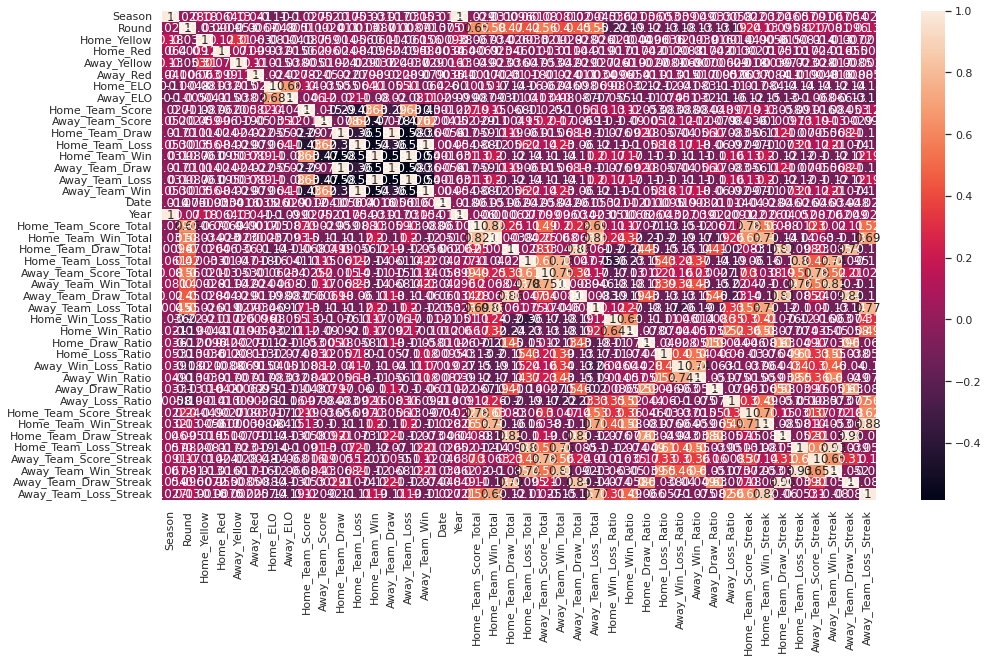

In [59]:
sns.heatmap(df.corr(), annot=True)

In [60]:
# Remove features of type object with likely limited importance if encoded

df.drop(
    columns=[
        'Home_Team', 'Away_Team', 'Result', 'Link',
        'League', 'Referee',
        'Stadium', 'Pitch', 'Capacity',
        'Region'], 
        inplace=True)

# Remove time, day, date, month and year features as don't appear to add any extra value
df.drop(columns=['Time', 'Day', 'Date', 'Month', 'Year'], inplace=True)


# Remove away team features as perfectly correlated with home team result

df.drop(columns=['Away_Team_Result', 'Away_Team_Win', 'Away_Team_Draw', 'Away_Team_Loss'], inplace=True)

# Remove scores as not availabel prior to fixture for prediction

df.drop(columns=['Home_Team_Score', 'Away_Team_Score'], inplace=True)

# Remove home team result dummies as this is effectively the target variable

df.drop(columns=['Home_Team_Win', 'Home_Team_Draw', 'Home_Team_Loss'], inplace=True)

df

Season  Round  Home_Yellow  Home_Red  Away_Yellow  Away_Red  Home_ELO  \
0       1990.0    1.0     1.723568  0.067117      2.08971  0.093088      55.0   
1       1990.0    1.0     1.723568  0.067117      2.08971  0.093088      55.0   
2       1990.0    1.0     1.723568  0.067117      2.08971  0.093088      54.0   
3       1990.0    1.0     1.723568  0.067117      2.08971  0.093088      58.0   
4       1990.0    1.0     1.723568  0.067117      2.08971  0.093088      53.0   
...        ...    ...          ...       ...          ...       ...       ...   
121441  2021.0   34.0     2.000000  0.000000      2.00000  0.000000      52.0   
121442  2021.0   34.0     4.000000  0.000000      4.00000  1.000000      45.0   
121443  2021.0   34.0     2.000000  0.000000      1.00000  0.000000      50.0   
121444  2021.0   34.0     1.000000  0.000000      1.00000  0.000000      58.0   
121445  2021.0   34.0     1.000000  0.000000      2.00000  0.000000      54.0   

        Away_ELO Home_Team_Result  Home_Team_Score_Total  Home_Team_Win_Total  \
0           55.0             Draw                      0                    0   
1           69.0             Draw                      0                    0   
2           55.0              Win                      0                    0   
3           57.0              Win                      0                    0   
4           61.0              Win                      0                    0   
...          ...              ...                    ...                  ...   
121441      60.0             Loss                     33                    0   
121442      45.0             Loss                     33                    0   
121443      56.0             Draw                     66                    0   
121444      53.0             Loss                      0                    0   
121445      51.0             Draw                      0                    0   

        Home_Team_Draw_Total  Home_Team_Loss_Total  Away_Team_Score_Total  \
0                          0                     0                      0   
1                          0                     0                      0   
2                          0                     0                      0   
3                          0                     0                      0   
4                          0                     0                      0   
...                      ...                   ...                    ...   
121441                     0                    33                    198   
121442                     0                    33                     66   
121443                    33                     0                     66   
121444                     0                    33                    132   
121445                    33                     0                      0   

        Away_Team_Win_Total  Away_Team_Draw_Total  Away_Team_Loss_Total  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
121441                   33                     0                     0   
121442                   33                     0                     0   
121443                    0                    33                     0   
121444                   33                     0                     0   
121445                    0                    33                     0   

        Home_Win_Loss_Ratio  Home_Win_Ratio  Home_Draw_Ratio  Home_Loss_Ratio  \
0                       0.0             0.0              0.0              0.0   
1                       0.0             0.0              0.0              

<AxesSubplot:>

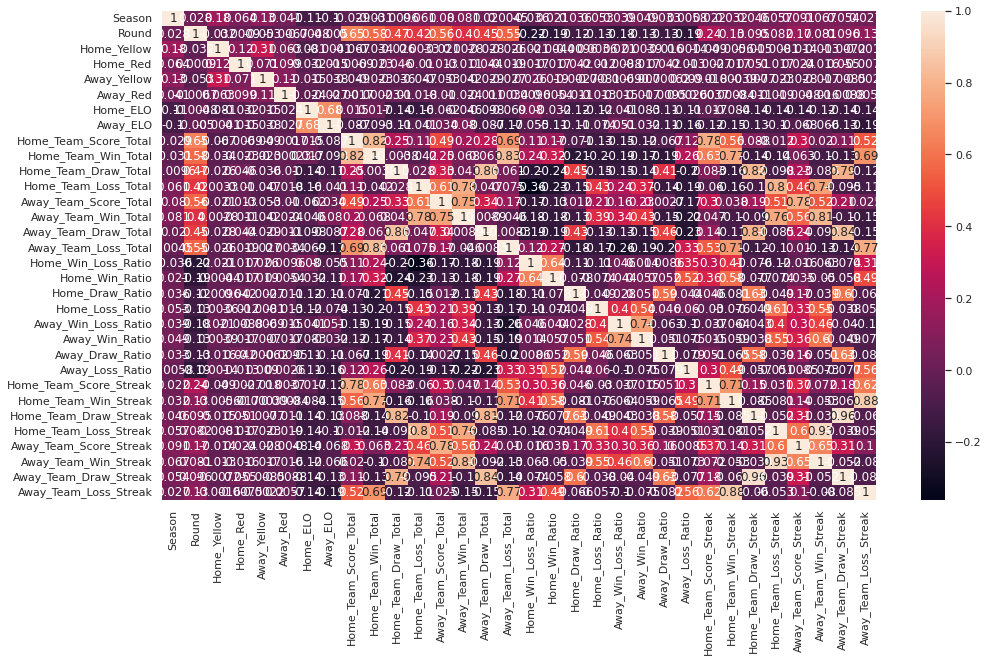

In [61]:
sns.heatmap(df.corr(), annot=True)

### Encoding, Splitting and Scaling Dataset

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121446 entries, 0 to 121445
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Season                  121446 non-null  float64
 1   Round                   121446 non-null  float64
 2   Home_Yellow             121446 non-null  float64
 3   Home_Red                121446 non-null  float64
 4   Away_Yellow             121446 non-null  float64
 5   Away_Red                121446 non-null  float64
 6   Home_ELO                121446 non-null  float64
 7   Away_ELO                121446 non-null  float64
 8   Home_Team_Result        121446 non-null  object 
 9   Home_Team_Score_Total   121446 non-null  int64  
 10  Home_Team_Win_Total     121446 non-null  uint8  
 11  Home_Team_Draw_Total    121446 non-null  uint8  
 12  Home_Team_Loss_Total    121446 non-null  uint8  
 13  Away_Team_Score_Total   121446 non-null  int64  
 14  Away_Team_Win_Total 

In [64]:
# Encode the target variable (classes)

enc = LabelEncoder()

df['Labels'] = enc.fit_transform(df['Home_Team_Result'])
df.drop(columns=['Home_Team_Result'], inplace=True)


In [72]:

classes = enc.classes_
print(classes)

classes_df = pd.DataFrame(classes)
classes_df


['Draw' 'Loss' 'Win']


In [75]:
# Create input features (X) and target variable (y)

X = df.drop(columns=['Labels'])
y = df['Labels']

X

In [ ]:
# Split the dataset into a training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, X.shape)

In [ ]:
# Scale the input variables

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape)


# Model Training

Create Instances of a range of classificatino models from sklearn

In [ ]:
# linear models
lr = LogisticRegression()
sgd = SGDClassifier()

# SVM models
svm = SVC()

# NB models
gnb = GaussianNB()

# neighbors models
knn = KNeighborsClassifier()

# tree models
dt = DecisionTreeClassifier()

# ensemble models
rfc = RandomForestClassifier()


In [ ]:
s = time.perf_counter()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('LR Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)
print('SGD Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('SVM Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print('GNB Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('KNN Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('DT Complete')
f = time.perf_counter()
print(f-s)

s = time.perf_counter()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('RFC Complete')
f = time.perf_counter()
print(f-s)

In [ ]:
'''
print('Performance of Logistic Regression Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_lr, target_names=classes))

print('Performance of SGD Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_sgd, target_names=classes))

print('Performance of SVM Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_svm, target_names=classes))

print('Performance of GNB Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_gnb, target_names=classes))

print('Performance of KNN Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_knn, target_names=classes))

print('Performance of Decision Tree Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_dt, target_names=classes))

print('Performance of Random Forest Classifier\n')
print(classification_report(y_true=y_test, y_pred=y_pred_rfc, target_names=classes))
'''

In [ ]:
preds = [y_pred_lr, y_pred_sgd, y_pred_svm, y_pred_gnb, y_pred_knn, y_pred_dt, y_pred_rfc]

idx = ['Linear Regression', 'SGD', 'SVM', 'GNB', 'KNN', 'Decision Tree', 'Random Forest']
cols = ['Precision', 'Recall', 'F_Score', 'Support']

performance_df = pd.DataFrame(index=idx, columns=cols)

for pred, ids in zip(preds, idx):
    result = precision_recall_fscore_support(y_true=y_test, y_pred=pred)
    precision, recall, f_score, support = result
    performance_df.loc[ids, 'Precision'] = precision
    performance_df.loc[ids, 'Recall'] = recall
    performance_df.loc[ids, 'F_Score'] = f_score
    performance_df.loc[ids, 'Support'] = support

performance_df

In [ ]:

unnested_lst = []
for col in performance_df.columns:
    unnested_lst.append(performance_df[col].apply(pd.Series).stack())
performance_df = pd.concat(unnested_lst, axis=1, keys=performance_df.columns)
performance_df

In [ ]:

performance_df.reset_index(inplace=True)
performance_df.rename(columns={'level_0':'Model', 'level_1':'Class'}, inplace=True)
performance_df['Class'] = performance_df['Class'].apply(lambda x: classes[x])
performance_df


In [ ]:
sns.barplot(data=performance_df, x='Model', y='Precision', hue='Class')

In [ ]:
sns.barplot(data=performance_df, x='Model', y='Recall', hue='Class')

In [ ]:
sns.barplot(data=performance_df, x='Model', y='F_Score', hue='Class')